# CO2 排放量达到 500 ppm

This notebook is a follow-on to the [CO2 after GRETA](https://www.kaggle.com/code/dan3dewey/co2-after-greta) notebook which monitored the Mauna Loa CO2 in the 5 years after the first global climate strike in March 2019. The goal was to monitor the CO2 ppm by comparing it to a Business as Usual model based on the 2009-2018 data. Small changes in CO2 would be more easily seen by looking at the difference between the new CO2 values and the BAU model predictions. A shift below BAU was expected because of the urgent actions that would certainly be taken given the new awareness brought by the climate strikes, especially since these followed not long after the wake-up IPCC 1.5 deg Special Report. 

Sadly, after an encouraging deviation to lower CO2 (starting in Jul 2020 and continuing through 2022), the CO2 curve took a sharp up-kink to increased rates in early 2023. In June 2024 this NOAA news item says it all: [During a year of extremes, carbon dioxide levels surge faster than ever](https://www.noaa.gov/news-release/during-year-of-extremes-carbon-dioxide-levels-surge-faster-than-ever) .

At the end of 2024, the data here show CO2 continuing its increase at a rate about 0.5 ppm/yr faster than the BAU path for a total rate of 3.5 ppm/yr. Continuing on this path, in 2030 the CO2 will exceed BAU and be increasing faster than BAU. This "BAU+" path will blow through 500 ppm by 2045, unless real emissions reductions and forest preservations are made. Exasperation with this lack of progress is veiled in humor in the subtitle of the [Emissions Gap Report 2024](https://www.unep.org/resources/emissions-gap-report-2024) : **"No more hot air - please!"**

In [1]:
!pip install -q -U pandas matplotlib numpy scikit-learn seaborn statsmodels openai requests

In [2]:
# If a local fonts/ directory exists, try to load fonts from it
from matplotlib import font_manager
import matplotlib as plt

import os, glob
font_dir = os.path.join(os.getcwd(), 'fonts')
loaded = []
if os.path.isdir(font_dir):
    for p in glob.glob(os.path.join(font_dir, '*.*')):
        try:
            font_manager.fontManager.addfont(p)
            loaded.append(p)
        except Exception:
            pass
names = [f.name for f in font_manager.fontManager.ttflist]
for n in ['Noto Sans CJK SC','Source Han Sans SC','Microsoft YaHei','SimHei','SimSun','Arial Unicode MS']:
    if n in names:
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = [n]
        plt.rcParams['axes.unicode_minus'] = False
        break
del names


In [3]:
# A few preliminaries

# usual things to use
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# for erf():
import math

# useful constant
DAYS_YR = 365.0

# Month labels
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
from matplotlib import font_manager
import os
def ensure_chinese_font():
    win_paths = [
        ('Microsoft YaHei', r'C\\Windows\\Fonts\\msyh.ttc'),
        ('SimHei', r'C\\Windows\\Fonts\\simhei.ttf'),
        ('SimSun', r'C\\Windows\\Fonts\\simsun.ttc'),
        ('KaiTi', r'C\\Windows\\Fonts\\kaiti.ttf'),
    ]
    for name, path in win_paths:
        try:
            if os.path.exists(path):
                font_manager.fontManager.addfont(path)
                plt.rcParams['font.family'] = 'sans-serif'
                plt.rcParams['font.sans-serif'] = [name]
                plt.rcParams['axes.unicode_minus'] = False
                return name
        except Exception:
            pass
    names = {f.name for f in font_manager.fontManager.ttflist}
    for name in ['Microsoft YaHei','SimHei','SimSun','Noto Sans CJK SC','Source Han Sans SC','Arial Unicode MS']:
        if name in names:
            plt.rcParams['font.family'] = 'sans-serif'
            plt.rcParams['font.sans-serif'] = [name]
            plt.rcParams['axes.unicode_minus'] = False
            return name
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    return None
ensure_chinese_font()

'Arial Unicode MS'

## Get and Setup the Weekly Data

In [4]:
# The weekly CO2 ppm file is linked on the page:  https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html
# and also via the "Trends in CO2" link on: https://www.esrl.noaa.gov/gmd/dv/data.html
# Specifically, it's available as a downloadable txt file at:
#     https://www.esrl.noaa.gov/gmd/webdata/ccgg/trends/co2/co2_weekly_mlo.txt
# The last measurement included in the weekly file is Saturday, six days after the last row's date.

# It's possible to read in the most recent file online:
# (This works in a Kaggle notebook if Settings --> Internet is set to "Internet on".)
# co2_file = "ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt"
# co2_file_date = '?'  # Will set this string from the data later in this file

# Or use a saved version from the CO2 Mauna Loa Weekly dataset
co2_file_date = '16Aug2025'
co2_file = "./co2_weekly_"+co2_file_date+".txt"

In [5]:
# Dates related to GT and major strikes
#
# GT school strike week 1, Friday 24 Aug 2018, day 236
yr_GTwk1 = 2018.0+(236.0-0.5)/DAYS_YR

# The first GRETA, 15 March 2019, day 74
yr_GRETA = 2019.0 + (74.0-0.5)/DAYS_YR
##print(yr_GRETA)    # 2019.20

# subsequent GRETA's:
# 3 May 2019, day 123 (more Canada, USA involvement)
yr_GRETA_mini = 2019.0 + (123.0-0.5)/DAYS_YR
# GRETA-2, 24 May 2019, day 144 
yr_GRETA_2 = 2019.0 + (144.0-0.5)/DAYS_YR
# The general global strikes:
# GRETA-General, 20[-27] September 2019, day 263 
yr_GRETA_General = 2019.0 + (263.0-0.5)/DAYS_YR
# The second general global strike, before COP 25:
# GRETA-General-2, 29 Nov 2019, day 333 
yr_GRETA_COP25 = 2019.0 + (333.0-0.5)/DAYS_YR
# GRETA: Global Day of Climate Action, 25 Sept. 2020
yr_GRETA_GDCA = 2020.0 + (269.0-0.5)/DAYS_YR
# GRETA: Global Climate Strike, 19 March 2021 #NoMoreEmptyPromises
yr_GRETA_NMEP = 2021.0 + (78.0-0.5)/DAYS_YR

# Other dates of note are in the code for the "weekly" or "future" plots, below;
# e.g., COP26 in Nov. 2021.


In [6]:
# Dates that select the "BAU" data to fit and how far to extrapolate

# Choose a starting time for fitting/analysis
yr_start = yr_GRETA - 10.0

# Choose to fit the data up until the first GRETA:
yr_fit = yr_GRETA   #  + 0.80  # 2020.0

# and extrapolate to some further time
yr_end = 2026.9  #yr_GRETA + 7.0

In [7]:
# Read the weekly CO2 data
df_co2 = pd.read_csv(co2_file, sep=r'\s+', comment='#', header=None,
            usecols=[0,1,2,3,4,5,6,7],
            names=['year','mm','dd','time','CO2_ppm','days','CO2_1yr','CO2_10yr'])
# Note: the decimal "time" in the file is the middle of the first day of the week;
#       add 3 days to it to be the middle of the week ...picky,picky...
df_co2['time'] = df_co2['time'] + 3.0/DAYS_YR

# Down-select to keep just data from the desired starting time
df_co2 = df_co2[df_co2['time'] > yr_start]


print("Read in the CO2 data in desired range:")
print(df_co2.head(6))
print( 6*"   . . .  ")
print(df_co2.tail(6))

# Are there any missed data points in the range?
df_gaps = df_co2[df_co2['CO2_ppm'] < 0.0]
# Patch them using the previous point and their 1 year ago values...
for indx in df_gaps.index:
    df_co2.loc[indx,'CO2_ppm'] = (df_co2.loc[indx-1,'CO2_ppm'] - df_co2.loc[indx-1,'CO2_1yr']) + \
        df_co2.loc[indx,'CO2_1yr']
print("Patched {} data points in this range.".format(len(df_gaps)))

Read in the CO2 data in desired range:
      year  mm  dd         time  CO2_ppm  days  CO2_1yr  CO2_10yr
1817  2009   3  15  2009.209619   388.42     7   386.07    370.34
1818  2009   3  22  2009.228719   389.51     6   386.89    370.93
1819  2009   3  29  2009.247919   389.26     7   388.06    370.64
1820  2009   4   5  2009.267119   389.65     7   387.32    371.95
1821  2009   4  12  2009.286319   389.15     6   386.68    371.54
1822  2009   4  19  2009.305519   389.78     7   386.80    370.42
   . . .     . . .     . . .     . . .     . . .     . . .  
      year  mm  dd         time  CO2_ppm  days  CO2_1yr  CO2_10yr
2668  2025   7   6  2025.519219   428.41     6   425.98    401.74
2669  2025   7  13  2025.538319   427.90     4   426.20    401.57
2670  2025   7  20  2025.557519   427.52     5   425.02    401.40
2671  2025   7  27  2025.576719   426.57     6   424.93    399.76
2672  2025   8   3  2025.595919   425.87     7   424.26    398.96
2673  2025   8  10  2025.615019   425.44  

In [8]:
# Generate the co2_file_date if not already set:
if co2_file_date == '?':
    last_row = df_co2.iloc[-1, :]
    day_num = int(last_row['dd']  + 6)
    month_num = int(last_row['mm'])
    year_num = int(last_row['year'])
    # kludge the month wrap-around
    if day_num > 29:
        day_num -= 30  # correct for 7 of the months :)
        month_num += 1
        if month_num > 12:
            month_num = 1
            year_num += 1
    co2_file_date = ( str(int(day_num)) + str(months[month_num - 1]) +
                             str(year_num) )
    print("File date set to:",co2_file_date)

In [9]:
# Augment the dataframe to go to the extrapolated time, yr_end.
# Calculate the number of weeks to add
last_index = df_co2.index[-1]
last_time = df_co2.loc[last_index, 'time']
week_yr = (7.0/DAYS_YR)
more_weeks = int((yr_end - last_time)/week_yr)
more_rows = []
# and create the augmented dataframe
df_co2_aug = df_co2.copy()
for iadd in range(1, more_weeks+1):
    new_time = last_time + iadd*week_yr
    df_co2_aug = pd.concat(
        [df_co2_aug, pd.DataFrame([{'year': int(new_time), 'mm': 0, 'dd': 0, 'time': new_time}])],
        ignore_index=True
    )

# Reset the index, drop the old index, and replace df_co2 with the augmented version:
df_co2 = df_co2_aug.reset_index().drop('index',axis=1)

# Add a yr_phase column:
df_co2['yr_phase'] = df_co2['time']-df_co2['time'].astype(int)


In [10]:
# Include GTweek numbers as well

# Find the index of the first school-strike week (it should be the week starting Sunday 19 Aug 2018).
# The "time" is mid-week so subtract some days from the Friday and use that week:
wk1_index = (df_co2.index[df_co2['time'] > (yr_GTwk1 - 4/DAYS_YR)])[0]

# Put GT-week numbers in the dataframe
df_co2['GTwk'] = 0
for wkind in range(wk1_index,len(df_co2)):
    df_co2.loc[wkind,'GTwk'] = 1 + df_co2.loc[wkind-1,'GTwk']
    
# GT-week-72 Friday is just into 2020, check it with:
##df_co2[df_co2['time'] > 2019.95].head(5)

# Show the dataframe columns around the start of the GT school strikes
df_co2[abs(df_co2['time'] - yr_GTwk1) < 30.0/DAYS_YR ]

year  mm  dd         time  CO2_ppm  days  CO2_1yr  CO2_10yr  yr_phase  \
488  2018   7  22  2018.563019   408.48   7.0   406.98    386.20  0.563019   
489  2018   7  29  2018.582219   407.65   6.0   406.69    385.30  0.582219   
490  2018   8   5  2018.601419   407.42   7.0   405.75    385.32  0.601419   
491  2018   8  12  2018.620519   407.26   7.0   405.59    384.14  0.620519   
492  2018   8  19  2018.639719   407.03   7.0   404.73    383.79  0.639719   
493  2018   8  26  2018.658919   406.30   7.0   404.47    383.51  0.658919   
494  2018   9   2  2018.678119   405.68   7.0   404.11    383.72  0.678119   
495  2018   9   9  2018.697219   405.58   7.0   403.77    383.28  0.697219   
496  2018   9  16  2018.716419   405.88   7.0   403.36    383.54  0.716419   

     GTwk  
488     0  
489     0  
490     0  
491     0  
492     1  
493     2  
494     3  
495     4  
496     5

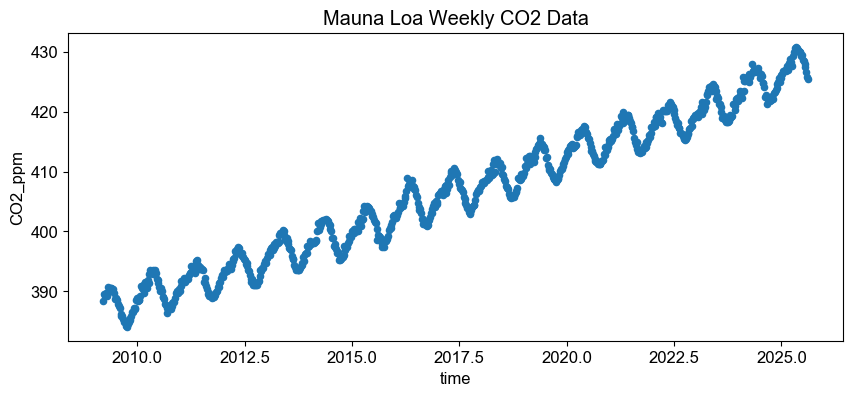

In [11]:
# Set the font size for plots
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# A quick plot of the data values
df_co2.plot.scatter('time','CO2_ppm',figsize=(10,4))
plt.title("Mauna Loa Weekly CO2 Data")
plt.show()

## <a id="FitData">Fit a Simple Model to the Data</a>
Back to <a href="#Index">Index</a>

The **Business-As-Usual** model is made by fitting the CO2 data with a secular component and a set of sin,cos harmonics  for the seasonal, periodic, components.  The secular component is a simple 3 parameter quadratic: ax^2 + b\*x + c with c the intercept, b the linear term, ppm/yr, and 2\*a the "acceleration" of the slope, ppm/yr/yr.

Note that in principle this model does not change, so all of this could be replaced by creating and reading-in a "BAU(2019)" model file. In practice, NOAA does infrequently update calibration values and make adjustments to the data, e.g., in February of 2021. So it's good to keep the (re-)fitting here in order to have an updated BAU.

In [12]:
# Use linear regression from the scikit-learn machine learning collection:
from sklearn.linear_model import LinearRegression

# The above routine was chosen since I'd been recently steeped in machine learning things.
# A more typical (and function-flexible) approach would be to use least squares fitting,
# e.g., curve_fit from scipy.optimize, as used by Adams at:
# https://piphase.wordpress.com/2019/06/03/climate-data-fourier-analysis/

In [13]:
# Setup the usual ML X,y data sets, includes future weeks as well
X = pd.DataFrame(df_co2[['time','yr_phase']])
y = pd.DataFrame(df_co2['CO2_ppm'])

# Add trend and periodic features to use in fitting

# Polynomial time functions, degree 1 to 5
# expand around yr_fit, use just linear and quadratic
time_ref = yr_fit
X['time1'] = (X['time'] - time_ref)
X['time2'] = (X['time'] - time_ref)**2

# Yearly shape
X['sin_t'] = np.sin(2.0*np.pi*X['yr_phase'])
X['cos_t'] = np.cos(2.0*np.pi*X['yr_phase'])
X['sin_2t'] = np.sin(4.0*np.pi*X['yr_phase'])
X['cos_2t'] = np.cos(4.0*np.pi*X['yr_phase'])
X['sin_3t'] = np.sin(6.0*np.pi*X['yr_phase'])
X['cos_3t'] = np.cos(6.0*np.pi*X['yr_phase'])
X['sin_4t'] = np.sin(8.0*np.pi*X['yr_phase'])
X['cos_4t'] = np.cos(8.0*np.pi*X['yr_phase'])
X['sin_5t'] = np.sin(10.0*np.pi*X['yr_phase'])
X['cos_5t'] = np.cos(10.0*np.pi*X['yr_phase'])
# Remove the phase and the time columns (time1 replaces time in fitting)
X = X.drop(['yr_phase','time'],axis=1).copy()


# Use simple linear regression
model = LinearRegression()

# Do the fitting on a limited time-range of the data
# Get the data to use for fitting, up to yr_fit:
fit_rows = df_co2['time'] < yr_fit
Xfit = X[fit_rows].copy()
yfit = y[fit_rows].copy()

# and do the fit
fit_model = model.fit(Xfit, yfit)

# The R^2 is very close to 1.00:
score = fit_model.score(Xfit, yfit)
print("The fit has R^2 = {:.4f}".format(score))

# Note: previous to Feb. 2021 this value was R^2 = 0.9942

The fit has R^2 = 0.9942


In [ ]:
# Put the model values in the original dataframe:
df_co2['BAU_ppm'] = fit_model.predict(X)

# along with residuals
df_co2['CO2_resid'] = df_co2['CO2_ppm'] - df_co2['BAU_ppm']

# and the model residual, i.e., zeros (for plotting)
df_co2['BAU_resid'] = 0.0

# Get the coefficients and intercept
cols = X.columns
coeffs = fit_model.coef_
intercept = fit_model.intercept_[0]
linear_coeff = coeffs[0,0]
ppmyryr_coeff = 2.0*coeffs[0,1]

# Show some useful values
print("The model coefficients at {:.2f} are:".format(time_ref))
print("  Intercept:  {:.2f}".format(intercept))
print("     Linear:  {:.3f} ppm/yr".format(linear_coeff))
# multiply the quadratic coef by 2 to get the "acceleration": 
print(" dLinear/dt:  {:.3f} ppm/yr/yr".format(ppmyryr_coeff))

# The peak value in May 2020
print("  2020 Peak:  {:.2f}".format(df_co2.loc[(df_co2['time'] < 2020.50), "BAU_ppm"].max()))


# List the periodic coefficients for reference.
print("The periodic sin,cos coeff.s are:", list(cols[2:]), "", coeffs[0,2:])

periodic_coeffs = (coeffs[0,2:]).copy()

# Note: previous to Feb. 2021 some values were: 2.702, 0.061, 417.39.

The model coefficients at 2019.20 are:
  Intercept:  410.98
     Linear:  2.705 ppm/yr
 dLinear/dt:  0.062 ppm/yr/yr
  2020 Peak:  417.60
The periodic sin,cos coeff.s are: ['sin_t', 'cos_t', 'sin_2t', 'cos_2t', 'sin_3t', 'cos_3t', 'sin_4t', 'cos_4t', 'sin_5t', 'cos_5t']  [ 2.94105606 -0.84774941 -0.61987612  0.7014939  -0.05058345  0.08760667
  0.05589956 -0.09704648  0.01422877 -0.01549063]


In [15]:
# Function to generate the periodic component for input times in years.
# This is put here after the coeff.s are shown; it is used farther below w/shift fitting.
def periodic_of_times(times_yr):
    phases = times_yr - np.floor(times_yr)
    pcfs = periodic_coeffs   #[ 2.94105606, -0.84774941, -0.61987612,  0.7014939,  -0.05058345,  0.08760667,
                          #0.05589956, -0.09704648,  0.01422877, -0.01549063]
    periodics = 0.0 * phases
    for iharm in range(1,5+1):
        periodics += pcfs[2*iharm-2]*np.sin(2*np.pi*iharm*phases)
        periodics += pcfs[2*iharm-1]*np.cos(2*np.pi*iharm*phases)
    return periodics

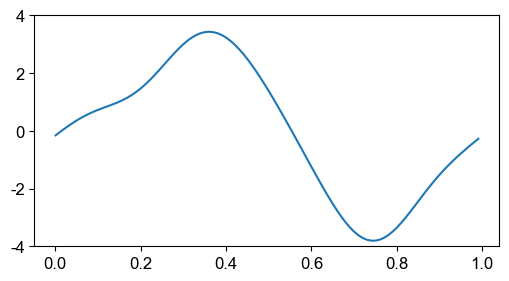

In [16]:
# Show the periodic_of_times(times_yr) routine's output,
# Can compare to inset plot at the very end.
plt.figure(figsize=(6,3.0))
plt_times = np.arange(0.001,0.999,0.01)
plt.plot(plt_times, periodic_of_times(plt_times) )
plt.ylim(-4,4)
plt.show()

In [17]:
# Create Data and Model columns with just secular or just periodic components

# Evaluate the model without the periodic terms:
df_co2['BAU_secular'] = intercept
for tpow in [1, 2]:
    df_co2['BAU_secular'] += X['time'+str(tpow)]*coeffs[0,tpow-1]
    
# Just the periodic part of the model, i.e., subtracting off the BAU_secular
df_co2['BAU_periodic'] = df_co2['BAU_ppm'] - df_co2['BAU_secular']


# Data: Create the secular ("deseasoned") Data, i.e., without periodic terms
df_co2['CO2_secular'] = df_co2['BAU_secular'] + df_co2['CO2_resid']

# Data: and the periodic Data without the secular terms:
df_co2['CO2_periodic'] = df_co2['BAU_periodic'] + df_co2['CO2_resid']

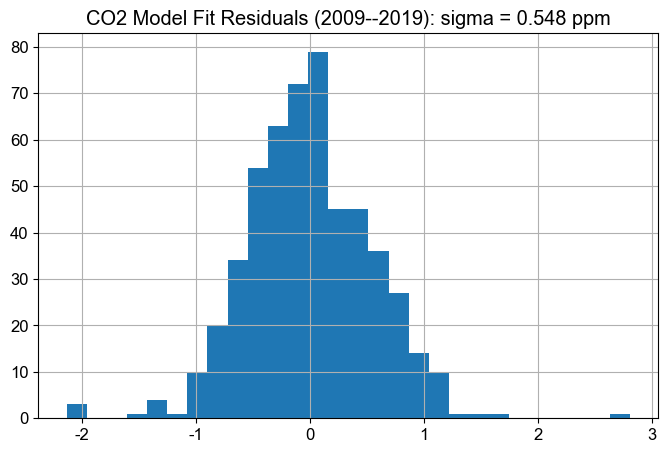

In [18]:
# Very approximate range of the model around the nominal 10-year fit:
model_std = 0.50
# Calculate the standard deviation of the fit residuals
df_stats = df_co2[fit_rows].describe()
resid_std = df_stats.loc['std','CO2_resid']

# Look at the distribution of the weekly residuals from the fit:
df_co2[fit_rows].hist(['CO2_resid'], bins='auto', figsize=(8,5))
plt.title("CO2 Model Fit Residuals ({}--{}): sigma = {:.3f} ppm".format(int(yr_start), int(yr_fit), resid_std))
plt.show()

## Calculate the IPCC SR15 future CO$_2$ levels

The desired IPCC SR15 future curve is the same as the BAU model until 15 March 2019: at this time the "acceleration" of the rate, the ppm/yr/yr value, is changed to be the desired (negative) value -- i.e., some brakes are put on, producing a deceleration.

See the [CO2 after GRETA](https://www.kaggle.com/code/dan3dewey/co2-after-greta) notebook for details on the values and equations used here.

In [19]:
# The IPCC Special Report "Global Warming of 1.5 C" suggests emissions paths with
# "no or limited overshoot" will have 2030 emissions ~45% below 2010 levels.

# To get the desired SR15 ppm/yr/yr, use parameters:
yr_reduced = yr_GRETA + 5.0   # reduction in 5 years, at 2024.20
reduced_to_fraction = 0.859**5   # reduced to x0.469 in five years

# Use these values to calculate the needed ppm/yr/yr.
# Note "linear_coeff" is the starting ppm/yr value ~ 2.701. 
new_ppmyryr = (reduced_to_fraction - 1)*linear_coeff/(yr_reduced - yr_fit)

print("Setting dLinear/dt to {:.3f} ppm/yr/yr ".format(new_ppmyryr) +
     "to decrease the ppm/yr rate to {:.1f}% of its value at {:.2f}".format(
         100.0*reduced_to_fraction, yr_reduced))

# Because the model is quadratic there is a constant *absolute* change
# in the ppm/yr rate from year to year; not the constant fractional change of an exponential.
# This means that the *fractional* change in ppm/yr is not constant for this model:
print("The percent change in ppm/yr varies with the year, some examples:")
print("= {:.2f}% in first year,".format(100.0*new_ppmyryr/linear_coeff))
print("= {:.2f}% in fifth year.".format(100.0*new_ppmyryr/(linear_coeff+4.0*new_ppmyryr)))

# Beyond the 5 years, the model is not appropriate.

Setting dLinear/dt to -0.288 ppm/yr/yr to decrease the ppm/yr rate to 46.8% of its value at 2024.20
The percent change in ppm/yr varies with the year, some examples:
= -10.65% in first year,
= -18.54% in fifth year.


In [20]:
# Calculate the SR15 model values

# Generate the SR15 secular term
df_co2['SR15_secular'] = intercept
df_co2['SR15_secular'] += X['time1']*linear_coeff
# Include a factor of 0.5 in the quadratic coeff. (i.e., as in physics: (1/2)at^2 )
df_co2['SR15_secular'] += X['time2']*0.5*new_ppmyryr

# Discontinue the SR15 model after fifth year,
# it looks strange to have it end, but it's no longer meaningful.
invalid_sr15_model = df_co2['time'] > yr_fit + 5.50
df_co2.loc[invalid_sr15_model,'SR15_secular'] = np.nan

# A version including the periodic model component
df_co2['SR15_ppm'] = df_co2['SR15_secular'] + df_co2['BAU_periodic']

# And create the "residual" of the SR15 and BAU model:
df_co2['SR15_resid'] = df_co2['SR15_ppm'] - df_co2['BAU_ppm']

# Create the SR15_periodic to be SR15_ppm minus BAU_secular:
# this is analogous to BAU_periodic which gives the BAU model minus the BAU secular term.
df_co2['SR15_periodic'] = df_co2['SR15_ppm'] - df_co2['BAU_secular']

In [21]:
# Output and check the SR15 model ppm and ppm/dt at some time in future
this_yr = 2024.20   # Five years from GRETA

# Show all the df values at this_yr and the following week:
##print((df_co2[df_co2['time'] > this_yr]).head(2))

# Calculate the ppm/yr values for BAU and SR15 models:
one_week = (df_co2[df_co2['time'] > this_yr]).iloc[0]
next_week = (df_co2[df_co2['time'] > this_yr]).iloc[1]

bau_ppmyr = (next_week['BAU_secular']- one_week['BAU_secular'])/(next_week['time']- one_week['time'])
sr15_ppmyr = (next_week['SR15_secular']- one_week['SR15_secular'])/(next_week['time']- one_week['time'])

# Calculate the ppm/yr/yr values too
bau_ppmyryr = (bau_ppmyr - linear_coeff)/(this_yr - yr_fit)
sr15_ppmyryr = (sr15_ppmyr - linear_coeff)/(this_yr - yr_fit)

print("Check the models at t =",this_yr," :")
print("          ppm     ppm/yr    ppm/yr/yr")
print(" BAU:   {:.3f}    {:.3f}    +{:.3f}".format(one_week['BAU_ppm'], bau_ppmyr, bau_ppmyryr))
print("SR15:   {:.3f}    {:.3f}    {:.3f}".format(one_week['SR15_ppm'], sr15_ppmyr, sr15_ppmyryr))

Check the models at t = 2024.2  :
          ppm     ppm/yr    ppm/yr/yr
 BAU:   427.021    3.016    +0.062
SR15:   422.619    1.258    -0.289


## The newest data point values

In [22]:
# determine the time, etc of the newest measurement
yr_newest = max(df_co2.loc[df_co2['CO2_ppm'] > 0.0,'time'])
newest_row = (df_co2[df_co2['time'] > (yr_newest - 0.001)]).iloc[0]
# and one year before that
yr_ago_row = (df_co2[df_co2['time'] > (yr_newest - 1.001)]).iloc[0]

# get specific newest values
GTwk_newest = int(newest_row['GTwk'])
ppm_newest = newest_row['CO2_ppm']
bau_newest = newest_row['BAU_ppm']
sr15_newest = newest_row['SR15_ppm']
secular_newest = newest_row['CO2_secular']
resid_newest = newest_row['CO2_resid']
phase_newest = newest_row['yr_phase']
periodic_newest = newest_row['CO2_periodic']

print(" CO2 is "+
      "{:.2f} ppm [{:.2f} deseasoned] in GT week {} (t={:.2f}).".format(
          ppm_newest, secular_newest, GTwk_newest, yr_newest))
print(" {:.2f} ppm from BAU ({:.2f}). ".format(resid_newest,bau_newest))

 CO2 is 425.44 ppm [427.08 deseasoned] in GT week 365 (t=2025.62).
 -2.52 ppm from BAU (427.96). 


In [23]:
print(newest_row)

year             2025.000000
mm                  8.000000
dd                 10.000000
time             2025.615019
CO2_ppm           425.440000
days                5.000000
CO2_1yr           421.930000
CO2_10yr          399.370000
yr_phase            0.615019
GTwk              365.000000
BAU_ppm           427.959605
CO2_resid          -2.519605
BAU_resid          -2.519605
BAU_secular       429.604593
BAU_periodic       -1.644988
CO2_secular       427.084988
CO2_periodic       -4.164593
SR15_secular             NaN
SR15_ppm                 NaN
SR15_resid               NaN
SR15_periodic            NaN
Name: 856, dtype: float64


## Simple Plots of the Data and Models

In [24]:
# Colors for components
fit_data_clr = 'blue'
new_data_clr = 'green'
bau_model_clr = 'salmon'
sr15_model_clr = 'limegreen'
# used further below:
met_ppm_clr = 'darkorange'

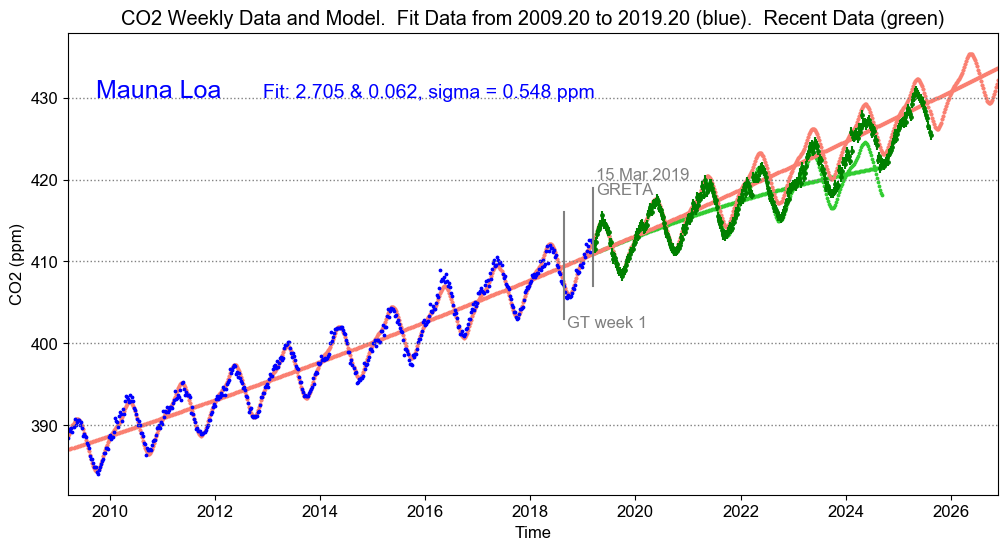

In [25]:
# - - - - - 
# Overview Plot

# The models
ax = df_co2.plot.scatter('time','BAU_ppm',c=bau_model_clr,s=3,figsize=(12,6))
# The SR15 secular trend
df_co2[~fit_rows].plot.scatter('time','SR15_secular',c=sr15_model_clr,s=3,ax=ax)
# The SR15 full model
df_co2[~fit_rows].plot.scatter('time','SR15_ppm',c=sr15_model_clr,s=3,ax=ax)
# BAU on top
df_co2.plot.scatter('time','BAU_secular',c=bau_model_clr,s=3,ax=ax)
df_co2.plot.scatter('time','BAU_ppm',c=bau_model_clr,s=3,ax=ax)

# data used for fitting
df_co2[fit_rows].plot.scatter('time','CO2_ppm',c=fit_data_clr,s=3,ax=ax)
# new data
df_co2[~fit_rows].plot.scatter('time','CO2_ppm',c=new_data_clr,s=6, yerr=resid_std, ax=ax)

# Plot limits
plt.xlim([yr_start,yr_end])
##plt.ylim([,])
# show grid(s)?
plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)

plt.title("CO2 Weekly Data and Model.  Fit Data from {:.2f} to {:.2f} (".format(yr_start, yr_fit) + 
          fit_data_clr+")." +
         "  Recent Data ("+new_data_clr+")")
# GRETA
plt.plot([yr_GRETA,yr_GRETA],[407,419],c="gray")
plt.text(yr_GRETA+0.05, 420.0,"15 Mar 2019",color="gray")
plt.text(yr_GRETA+0.05, 418.2,"GRETA", color="gray")
# GT week 1
plt.plot([yr_GTwk1,yr_GTwk1],[407-4,419-3],c="gray")
plt.text(yr_GTwk1+0.05, 402.0,"GT week 1", color="gray")

# Show which data set this is from and the fit information
plt.text(0.06-0.03, 0.86, "Mauna Loa", color=fit_data_clr,
         transform=ax.transAxes, fontsize=18)
info_str = ("Fit: {:.3f}".format(linear_coeff) + 
            " & {:.3f}".format(ppmyryr_coeff) +
           ", sigma = {:.3f} ppm".format(resid_std))
plt.text(0.06+0.15, 0.86, info_str, color=fit_data_clr,
         transform=ax.transAxes, fontsize=14)

# Kaggle notebook url
plt.text(2016.0, 385.0, "", color="gray")

plt.ylabel("CO2 (ppm)")
plt.xlabel("Time")
plt.savefig("CO2headingto500ppm_10yrs_"+co2_file_date+".png")
plt.show()

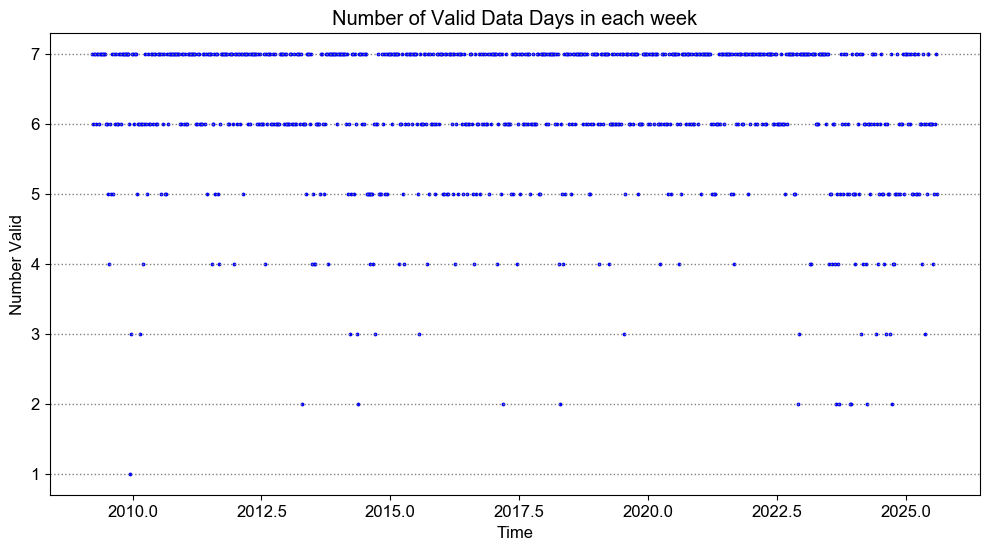

In [26]:
# - - - - - 
# Number of valid-data-days in each Week

ax = df_co2.plot.scatter('time','days',c=fit_data_clr,s=3,figsize=(12,6))
# show grid(s)?
plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)
plt.title("Number of Valid Data Days in each week")
plt.ylabel("Number Valid")
plt.xlabel("Time")
plt.savefig("CO2headingto500ppm_ValidDays_"+co2_file_date+".png", bbox_inches='tight')
plt.show()

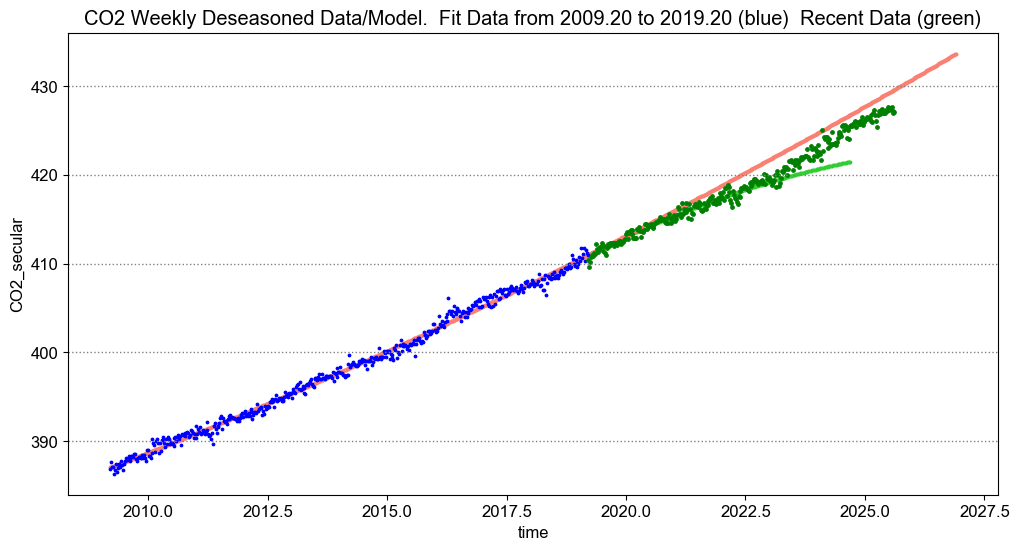

In [27]:
# - - - - - 
# Trends Plot

# The Secular models
ax = df_co2.plot.scatter('time','BAU_secular',c=bau_model_clr,alpha=0.5,s=3, figsize=(12,6))
df_co2[~fit_rows].plot.scatter('time','SR15_secular',c=sr15_model_clr,s=3,ax=ax)
# BAU on top:
df_co2.plot.scatter('time','BAU_secular',c=bau_model_clr,s=3,ax=ax)

df_co2[fit_rows].plot.scatter('time','CO2_secular',c=fit_data_clr,s=3,ax=ax)
df_co2[~fit_rows].plot.scatter('time','CO2_secular',c=new_data_clr,s=6, ax=ax)
                               ##yerr=resid_std)   # include error bars on new data?

# show grid(s)?
plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)

plt.title("CO2 Weekly Deseasoned Data/Model.  Fit Data from {:.2f} to {:.2f} (".format(yr_start, yr_fit) +
         fit_data_clr+")  Recent Data ("+new_data_clr+")")

plt.savefig("CO2headingto500ppm_AllDeseasoned_"+co2_file_date+".png", bbox_inches='tight')
plt.show()

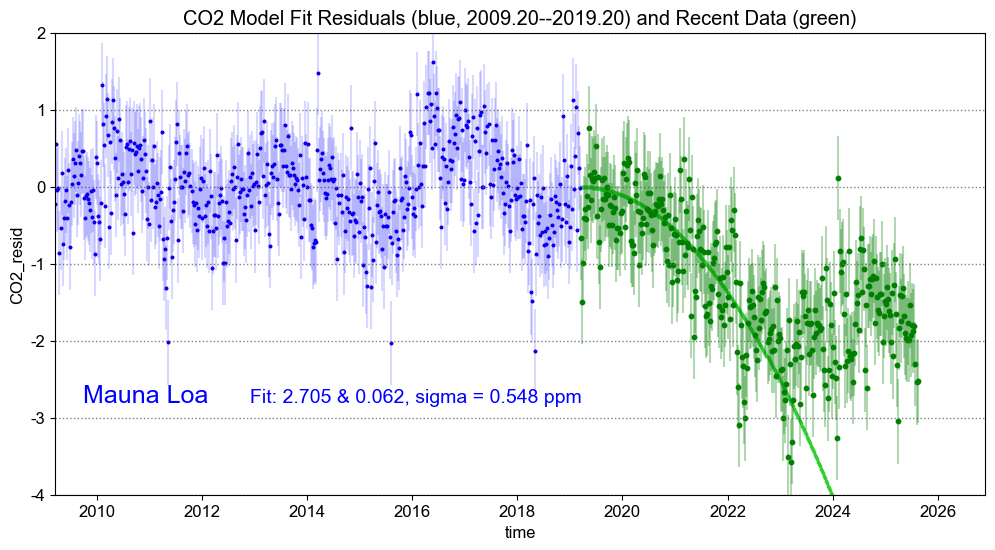

In [28]:
# - - - - - 
# Residuals Plot

# The residuals between data and model
# Model of the residuals = 0:
ax = df_co2.plot.scatter('time','BAU_resid',c=bau_model_clr,alpha=0.5,s=3, figsize=(12,6))
# Residuals for SR15 model:
df_co2[~fit_rows].plot.scatter('time','SR15_resid',c=sr15_model_clr,s=3,ax=ax)
# BAU on top:
df_co2.plot.scatter('time','BAU_resid',c=bau_model_clr,s=3,ax=ax)

# residuals of fit data
df_co2[fit_rows].plot.scatter('time','CO2_resid',c=fit_data_clr,alpha=0.15,s=1, yerr=resid_std, ax=ax)
df_co2[fit_rows].plot.scatter('time','CO2_resid',c=fit_data_clr,s=3,ax=ax)
# residuals of the new data
df_co2[~fit_rows].plot.scatter('time','CO2_resid',c=new_data_clr,alpha=0.3,s=1, yerr=resid_std, ax=ax)
df_co2[~fit_rows].plot.scatter('time','CO2_resid',c=new_data_clr,s=10, ax=ax)

# Plot limits
plt.xlim([yr_start,yr_end])
plt.ylim([-4.0,2.0])
# show grid(s)?
plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)

# Show which data set this is
plt.text(0.06-0.03, 0.20, "Mauna Loa", color=fit_data_clr,
         transform=ax.transAxes, fontsize=18)
info_str = ("Fit: {:.3f}".format(linear_coeff) + 
            " & {:.3f}".format(ppmyryr_coeff) +
           ", sigma = {:.3f} ppm".format(resid_std))
plt.text(0.06+0.15, 0.20, info_str, color=fit_data_clr,
         transform=ax.transAxes, fontsize=14)

plt.title("CO2 Model Fit Residuals ("+fit_data_clr+", {:.2f}--{:.2f}) and Recent Data (".format(
        yr_start, yr_fit) + new_data_clr + ")")

plt.savefig("CO2headingto500ppm_AllResids_"+co2_file_date+".png", bbox_inches='tight')
plt.show()

## Fancy Plots to Publicize

These are similar to the plots above but made with selected variable ranges.

These plots also have more annotations on the them, which bloats their code.  **:(**

In [29]:
# Routines to add some labels to the plots

# Data fit for prediction
def describe_fit_data(xfrac, yfrac, ax):
    spacing = 0.04
    fontsize = 14
    plt.text(xfrac, yfrac, "Pre-GRETA Data ("+fit_data_clr+")",color=fit_data_clr,
         transform=ax.transAxes, fontsize=fontsize)
    plt.text(xfrac, yfrac-spacing, "  Previous {} years".format(int(0.50+yr_fit - yr_start)),color=fit_data_clr,
         transform=ax.transAxes, fontsize=fontsize)
    plt.text(xfrac, yfrac-2*spacing, "used to fit the BAU Model",color=fit_data_clr,
         transform=ax.transAxes, fontsize=fontsize)
    plt.text(xfrac, yfrac-3*spacing, "(Source: NOAA ESRL)",color=fit_data_clr,
         transform=ax.transAxes, fontsize=fontsize)

# BAU model info
def describe_bau(xfrac, yfrac, ax):
    spacing = 0.04
    fontsize = 14
    plt.text(xfrac, yfrac, "Business as Usual Model ",
             color=bau_model_clr, transform=ax.transAxes, fontsize=fontsize)
    ##plt.text(xfrac+0.020, yfrac-spacing, "Linear:  {:.3f} ppm/yr".format(coeffs[0,0]),
    ##         color=bau_model_clr, transform=ax.transAxes, fontsize=fontsize)
    ##plt.text(xfrac-0.02, yfrac-2*spacing, "  dLinear/dt:  {:.3f} ppm/yr /yr".format(2.0*coeffs[0,1]),
    ##         color=bau_model_clr, transform=ax.transAxes, fontsize=fontsize)
    plt.text(xfrac-0.01, yfrac-spacing, "Close to worst-case RCP8.5",
             color=bau_model_clr, transform=ax.transAxes, fontsize=fontsize)
    plt.text(xfrac-0.01, yfrac-2*spacing, "500 ppm and rising in 2045",
             color=bau_model_clr, transform=ax.transAxes, fontsize=fontsize)
    
# IPCC SR15 model
def describe_sr15(xfrac, yfrac, ax):
    spacing = 0.04
    fontsize = 14
    plt.text(xfrac, yfrac,"IPCC 1.5 deg. Model (P2)",color=sr15_model_clr,
         transform=ax.transAxes, fontsize=fontsize)
    plt.text(xfrac+0.02, yfrac-spacing, "$-$6.7 %/yr emissions", color=sr15_model_clr,
         transform=ax.transAxes, fontsize=fontsize)
    ##plt.text(xfrac+0.02, yfrac-2*spacing,"gives {:.3f} ppm/yr/yr".format(new_ppmyryr),color=sr15_model_clr,
    ##     transform=ax.transAxes, fontsize=fontsize)
    plt.text(xfrac+0.02, yfrac-2*spacing,"(what could have been)",color=sr15_model_clr,
         transform=ax.transAxes, fontsize=fontsize)
    
# And the file date string:
co2_file_date_str = co2_file_date[:-7]+" "+co2_file_date[-7:-4]+" "+co2_file_date[-4:]

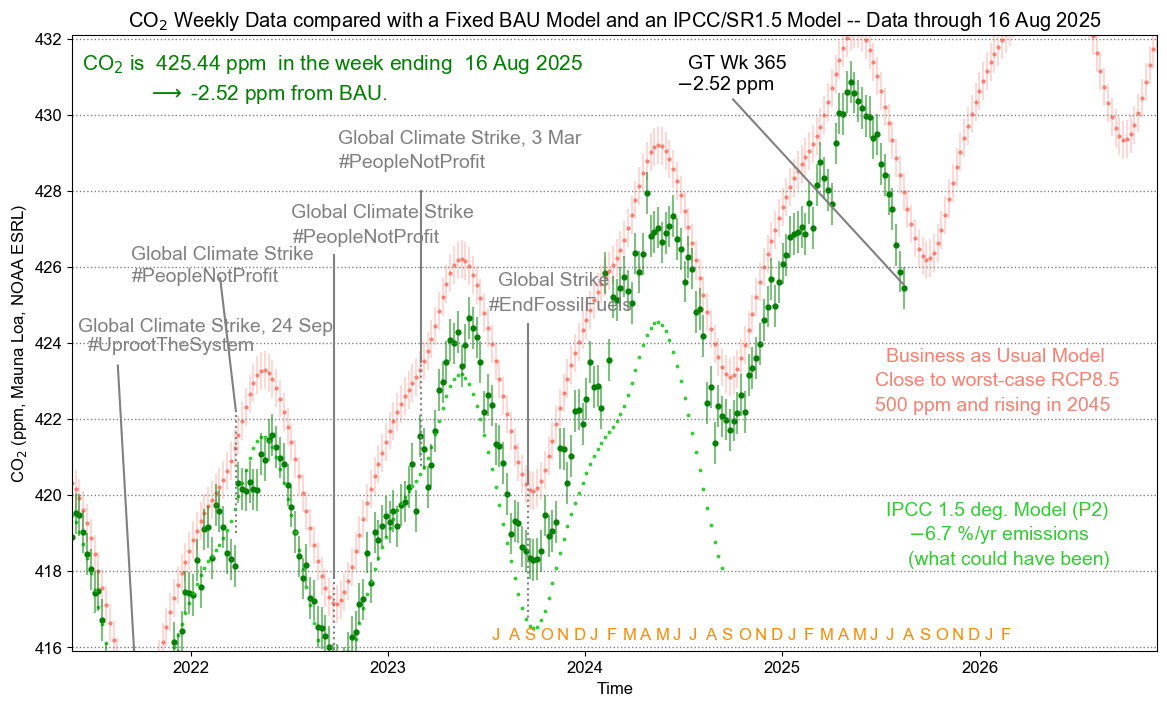

In [30]:
# - - - - -
# This plot focusses on the recent past and future year or so...
# Include labels for significant events.

# Starting and stopping years for data on the plot
yr_plt_start = 2021.4
yr_plt_stop = yr_end

# Model and Data, ppm values 
# show the BAU model and set the y-axis limits
ax = df_co2.plot.scatter('time','BAU_ppm',c=bau_model_clr,s=3,figsize=(14,8),
                xlim=(yr_plt_start,yr_plt_stop), ylim=(409.9+6, 424.1+8))
# with error bars
df_co2.plot.scatter('time','BAU_ppm',c=bau_model_clr,alpha=0.3,s=1,yerr=model_std,ax=ax)

# Data used for fitting the model, w/errors - this pre-dates the range of this plot
##df_co2[fit_rows].plot.scatter('time','CO2_ppm',c=fit_data_clr,alpha=0.3,s=1,yerr=resid_std,ax=ax)
##df_co2[fit_rows].plot.scatter('time','CO2_ppm',c=fit_data_clr,s=12,ax=ax)

# Post-GRETA (aka new era) data, w/errors
df_co2[~fit_rows].plot.scatter('time','CO2_ppm',c=new_data_clr,alpha=0.5,yerr=resid_std,s=1, ax=ax)
df_co2[~fit_rows].plot.scatter('time','CO2_ppm',c=new_data_clr,s=12, ax=ax)

# The IPCC SR15 full model
df_co2[~fit_rows].plot.scatter('time','SR15_ppm',c=sr15_model_clr,s=3,ax=ax)
# put BAU on top
df_co2.plot.scatter('time','BAU_ppm',c=bau_model_clr,s=3,ax=ax)

# Add month names in (some parts of) some year(s)
ppm_month = 416.2
for imon, month in enumerate(months):
    frac_year = (imon+0.3)/12.0
    if imon >= 7-1:
        plt.text(2023.00+0.0+frac_year, ppm_month, month[0],color=met_ppm_clr)
    plt.text(2024.00+0.0+frac_year, ppm_month, month[0],color=met_ppm_clr)
    plt.text(2025.00+0.0+frac_year, ppm_month, month[0],color=met_ppm_clr)
    if imon <= 2-1:
        plt.text(2026.00+0.0+frac_year, ppm_month, month[0],color=met_ppm_clr)
# show grid(s)?
plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)

# title and axis labels
plt.title("CO$_2$ Weekly Data compared with a Fixed BAU Model" +
         " and an IPCC/SR1.5 Model -- Data through "+co2_file_date_str)

plt.ylabel("CO$_2$ (ppm, Mauna Loa, NOAA ESRL)")
plt.xlabel("Time")


# Add various annotations on the plot

# Label with the key information
info_string = ("CO$_2$ is  {:.2f} ppm  in the week ending  ".format(ppm_newest) +
          co2_file_date[:-7]+" "+co2_file_date[-7:-4]+" "+co2_file_date[-4:])
plt.text(2021.45, 425.2+6.0, info_string, color=new_data_clr, fontsize=15)
#
# State the relation to BAU:
abovebelow = 'from'
rel_bau_string = ("$ \\longrightarrow $ {:.2f} ppm ".format(resid_newest) + 
                  abovebelow + " BAU.")
plt.text(2021.78, 424.4+6.0, rel_bau_string, color=new_data_clr, fontsize=15)


# Current GT week:   move this now and then
yr_label = 2024.50
ppm_label = 431.30
# line segment to it and text
plt.plot([yr_newest-0.0025, yr_label+0.25],[ppm_newest+0.10, ppm_label-0.90],
         c="gray")
plt.text(yr_label+0.02, ppm_label-0.08,"GT Wk {}".format(GTwk_newest), fontsize=14, color='black')
# include the ppm residual-from-BAU value:
sign_str = "$+$"
if resid_newest < 0.0:
    sign_str = "$-$"
plt.text(yr_label-0.04, ppm_label-0.65, "{}{:.2f} ppm".format(sign_str,abs(resid_newest)),
         fontsize=14, color='black')


# _ _ _ Dates/events of note:

# Friday 24 Sep 2021: Global Climate Strike  
# https://fridaysforfuture.org/September24/   #UprootTheSystem
yr_GRETA_UTS = 2021.0 + 267.0/DAYS_YR
plt.plot([yr_GRETA_UTS, yr_GRETA_UTS-0.10], [414.3,420.4+3],c="gray")
plt.text(yr_GRETA_UTS-0.30, 421.3+3,"Global Climate Strike, 24 Sep", color="gray", fontsize=14)
plt.text(yr_GRETA_UTS-0.25, 421.3-0.5+3,"#UprootTheSystem", color="gray", fontsize=14)

# Global Climate Strike #PeopleNotProfit Friday 25 Mar 2022, day 84)
# ~ Three years since first GRETA.
yr_GRETA_PNP = 2022.0 + 84.0/DAYS_YR
plt.plot([yr_GRETA_PNP-0.0,yr_GRETA_PNP-0.08], [422.2, 423.2-0.5+3],c="gray")
plt.plot([yr_GRETA_PNP-0.0,yr_GRETA_PNP-0.0],
         [419.0, 422.2],c="gray",linestyle="dotted")
plt.text(yr_GRETA_PNP-0.53, 423.2+3,"Global Climate Strike", 
         color="gray", fontsize=14)
plt.text(yr_GRETA_PNP-0.53, 423.2-0.6+3,"#PeopleNotProfit", 
         color="gray", fontsize=14)

# Friday 23 Sep 2022: Global Climate Strike  
# https://fridaysforfuture.org/September23/   #PeopleNotProfit
yr_GRETA_PNP2 = 2022.0 + 266.0/DAYS_YR
plt.plot([yr_GRETA_PNP2, yr_GRETA_PNP2-0.0], [417.8,422.3+4],c="gray")
plt.plot([yr_GRETA_PNP2-0.0,yr_GRETA_PNP2-0.0], [417.7,414.5],
             c="gray",linestyle='dotted')
plt.text(yr_GRETA_PNP2-0.30, 423.3+4,"   Global Climate Strike",
             color="gray", fontsize=14)
plt.text(yr_GRETA_PNP2-0.210, 423.3-0.65+4,"#PeopleNotProfit",
             color="gray", fontsize=14)

# Global Strike, 3 March 2023 -- 4 years since first global strike.
yr_GRETA_4YR = 2023.0 +62.0/DAYS_YR
plt.text(yr_GRETA_4YR-0.42, 425.25+4,"Global Climate Strike, 3 Mar", color="gray", fontsize=14)
plt.text(yr_GRETA_4YR-0.42, 425.25-0.65+4,"#PeopleNotProfit", color="gray", fontsize=14)
plt.plot([yr_GRETA_4YR,yr_GRETA_4YR], [423.5,424.00+4],c="gray")
plt.plot([yr_GRETA_4YR,yr_GRETA_4YR], [420.75,423.5],c="gray",linestyle='dotted')

# Friday, Sunday 15, 17 Sep 2023: Global Climate Strike  
# https://fridaysforfuture.org/september15/   #EndFossilFuels
yr_GRETA_EFF = 2023.0 + 259.0/DAYS_YR
plt.plot([yr_GRETA_EFF, yr_GRETA_EFF-0.0], [420.3,424.5],c="gray")
plt.plot([yr_GRETA_EFF-0.0,yr_GRETA_EFF-0.0], [420.3,416.7],
             c="gray",linestyle='dotted')
plt.text(yr_GRETA_EFF-0.15, 425.5,"Global Strike",
             color="gray", fontsize=14)
plt.text(yr_GRETA_EFF-0.20, 425.5-0.65,"#EndFossilFuels",
             color="gray", fontsize=14)



# _ _ _ Future events:

# Global Climate strike 19 April 2024

# _ _ _
# Annotation text for the data, model, etc.
# BAU information
describe_bau(0.75, 0.47, ax)
# IPCC SR15 information
describe_sr15(0.75, 0.22, ax)    

# Kaggle notebook url
plt.text(2024.0, 417.0, "", color="gray")

plt.savefig("CO2headingto500ppm_weeks_"+co2_file_date+".png", bbox_inches='tight')
plt.show()


## Other Model Comparisons
Within the BAU framework we also tested regularized and ensemble methods:
- Ridge regression for robust fitting and coefficient shrinkage.
- Lasso for feature selection and sparsity.
- Gradient Boosting Regressor (GBR) scores highly on train but overfits in extrapolation (see metrics); not recommended for long-term trend projection.


In [31]:
from sklearn.linear_model import Ridge, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

valid_fit_mask = fit_rows & df_co2['CO2_ppm'].notna()
valid_post_mask = (~fit_rows) & df_co2['CO2_ppm'].notna()
Xfit = X[valid_fit_mask].copy()
yfit = df_co2.loc[valid_fit_mask, 'CO2_ppm'].values
Xpost = X[valid_post_mask].copy()
ypost = df_co2.loc[valid_post_mask, 'CO2_ppm'].values

pipe_ridge = Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0))])
pipe_lasso = Pipeline([('scaler', StandardScaler()), ('model', LassoCV(cv=5, random_state=0))])
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, subsample=0.8, random_state=0)

pipe_ridge.fit(Xfit, yfit)
df_co2['Ridge_ppm'] = pipe_ridge.predict(X)
df_co2['Ridge_resid'] = df_co2['CO2_ppm'] - df_co2['Ridge_ppm']

pipe_lasso.fit(Xfit, yfit)
df_co2['Lasso_ppm'] = pipe_lasso.predict(X)
df_co2['Lasso_resid'] = df_co2['CO2_ppm'] - df_co2['Lasso_ppm']

gbr.fit(Xfit, yfit)
df_co2['GBR_ppm'] = gbr.predict(X)
df_co2['GBR_resid'] = df_co2['CO2_ppm'] - df_co2['GBR_ppm']

def eval_model(name, yfit_pred, ypost_pred):
    m = np.isfinite(ypost) & np.isfinite(ypost_pred)
    tr_r2 = r2_score(yfit, yfit_pred)
    te_r2 = r2_score(ypost[m], ypost_pred[m])
    tr_rmse = (mean_squared_error(yfit, yfit_pred))**0.5
    te_rmse = (mean_squared_error(ypost[m], ypost_pred[m]))**0.5
    print(f'{name} | train R2={tr_r2:.4f} RMSE={tr_rmse:.3f} | test R2={te_r2:.4f} RMSE={te_rmse:.3f}')

eval_model('BAU(LR)', fit_model.predict(Xfit).ravel(), fit_model.predict(Xpost).ravel())
eval_model('Ridge', pipe_ridge.predict(Xfit), pipe_ridge.predict(Xpost))
eval_model('LassoCV', pipe_lasso.predict(Xfit), pipe_lasso.predict(Xpost))
eval_model('GBR', gbr.predict(Xfit), gbr.predict(Xpost))

BAU(LR) | train R2=0.9942 RMSE=0.547 | test R2=0.9200 RMSE=1.521
Ridge | train R2=0.9942 RMSE=0.551 | test R2=0.9654 RMSE=1.000
LassoCV | train R2=0.9940 RMSE=0.557 | test R2=0.9790 RMSE=0.778
GBR | train R2=0.9990 RMSE=0.224 | test R2=-6.5562 RMSE=14.779


✓ 已重新加载 llm_forecast_module
✓ 可用函数: ['call_llm_api', 'csv', 'datetime', 'extract_float', 'forecast_llm', 'forecast_llm_fair_comparison', 'json', 'load_cache', 'mae', 'mape']


/Users/buhanyunfei/Downloads/dataprocess/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# LLM预测模型
现在我们使用LLM（大语言模型）进行预测，并与传统方法进行公平比较。


In [ ]:
# LLM Prediction with Fair Comparison to Existing Methods
import os, json
from llm_forecast_module import (forecast_llm_fair_comparison, predict_future_with_llm, 
                                  mae, rmse, mape, load_cache, save_cache, save_csv, save_json)

# Configuration
MODEL = 'gpt-4o'
BASE_URL = os.environ.get('OPENAI_BASE_URL') or 'http://35.220.164.252:3888/v1'
API_KEY = os.environ.get('OPENAI_API_KEY') or 'sk-MXjylpx7b5vgbChsBnf0Lk98myRs1Ux88E74GBnzwdJG9Qp0'
CONTEXT_WEEKS = 12
OUT_DIR = 'results_notebook'
CACHE_FILE = os.path.join(OUT_DIR, 'llm_cache.json')
os.makedirs(OUT_DIR, exist_ok=True)

# Load cache
cache = load_cache(CACHE_FILE) if os.path.isfile(CACHE_FILE) else {}

print("="*60)
print("开始LLM预测...")
print("="*60)

# Generate LLM predictions using the same train/test split as other models
llm_results = forecast_llm_fair_comparison(df_co2, fit_rows, CONTEXT_WEEKS, API_KEY, MODEL, BASE_URL, cache, 'notebook')

# Initialize LLM predictions array
df_co2['LLM_ppm'] = llm_results['llm_ppm']

# === 使用LLM预测未来数据点（与其他模型公平对比）===
print("\n" + "="*60)
print("使用LLM API预测未来数据点...")
print("="*60)

# 使用真正的LLM预测未来点
future_predictions = predict_future_with_llm(df_co2, CONTEXT_WEEKS, API_KEY, MODEL, BASE_URL, cache)

# 将预测结果填入dataframe
for idx, pred in future_predictions.items():
    df_co2.loc[idx, 'LLM_ppm'] = pred

# Save cache
save_cache(cache, CACHE_FILE)

# 计算残差
df_co2['LLM_resid'] = df_co2['CO2_ppm'] - df_co2['LLM_ppm']

# Print evaluation metrics for fair comparison
print("\n" + "="*60)
print("LLM模型评估结果:")
print("="*60)
print(f"训练期 R²={llm_results['train_r2']:.4f}, RMSE={llm_results['train_rmse']:.3f} ppm")
print(f"测试期 R²={llm_results['test_r2']:.4f}, RMSE={llm_results['test_rmse']:.3f} ppm")

# 统计预测覆盖率
total_points = len(df_co2)
predicted_points = df_co2['LLM_ppm'].notna().sum()
future_points = len(future_predictions)
print(f"\n预测统计:")
print(f"  总数据点: {total_points}")
print(f"  已预测点: {predicted_points}")
print(f"  覆盖率: {100*predicted_points/total_points:.1f}%")
print(f"  未来点: {future_points}")
print("="*60)


开始LLM预测...

正在生成训练期LLM预测（从第12个点开始）...
  训练期: 已完成 50/522 个预测
  训练期: 已完成 100/522 个预测
  训练期: 已完成 150/522 个预测
  训练期: 已完成 200/522 个预测
  训练期: 已完成 250/522 个预测
  训练期: 已完成 300/522 个预测
  训练期: 已完成 350/522 个预测
  训练期: 已完成 400/522 个预测
  训练期: 已完成 450/522 个预测
  训练期: 已完成 500/522 个预测

正在生成测试期LLM预测...
  测试期: 已完成 20/335 个预测
  测试期: 已完成 40/335 个预测
  测试期: 已完成 60/335 个预测
  测试期: 已完成 80/335 个预测
  测试期: 已完成 100/335 个预测
  测试期: 已完成 120/335 个预测
  测试期: 已完成 140/335 个预测
  测试期: 已完成 160/335 个预测
  测试期: 已完成 180/335 个预测
  测试期: 已完成 200/335 个预测
  测试期: 已完成 220/335 个预测
  测试期: 已完成 240/335 个预测
  测试期: 已完成 260/335 个预测
  测试期: 已完成 280/335 个预测
  测试期: 已完成 300/335 个预测
  测试期: 已完成 320/335 个预测

使用LLM API预测未来数据点...

使用LLM预测 67 个未来数据点
上下文窗口: 52 周（最后观测: 2025.6150）
预测策略: 基于历史真实数据，不使用预测值避免误差累积
  已完成 10/67 个预测
  已完成 20/67 个预测
  已完成 30/67 个预测
  已完成 40/67 个预测
  已完成 50/67 个预测
  已完成 60/67 个预测
✓ 完成所有 67 个未来点的LLM预测


LLM模型评估结果:
训练期 R²=0.9916, RMSE=0.656 ppm
测试期 R²=0.9840, RMSE=0.680 ppm

预测统计:
  总数据点: 924
  已预测点: 402
  覆盖率: 43.5%
  未来点: 67


## 各模型详细可视化分析

为每个模型（Ridge、Lasso、GBR、LLM）创建类似BAU的详细可视化分析，包括：
- 时间序列预测图
- 残差分析图  
- 去季节化趋势图
- 性能统计摘要

最后将所有模型的结果放在同一个图中进行综合对比。


In [34]:
# 定义模型颜色和信息
model_colors_dict = {
    'Ridge': 'royalblue',
    'Lasso': 'darkorange', 
    'GBR': 'purple',
    'LLM': 'red'
}

model_names_cn = {
    'Ridge': 'Ridge回归 (L2正则化)',
    'Lasso': 'Lasso回归 (L1正则化)',
    'GBR': '梯度提升回归',
    'LLM': '大语言模型预测'
}

# 创建通用可视化函数
def plot_model_analysis(model_name, ppm_col, resid_col, model_color, save_prefix):
    """
    为单个模型创建详细的可视化分析（类似BAU的风格）
    
    参数:
    - model_name: 模型名称（中文）
    - ppm_col: PPM预测列名
    - resid_col: 残差列名
    - model_color: 模型颜色
    - save_prefix: 保存文件的前缀
    """
    
    # 计算模型统计信息
    valid_mask = df_co2[ppm_col].notna() & df_co2['CO2_ppm'].notna()
    train_mask = fit_rows & valid_mask
    test_mask = (~fit_rows) & valid_mask
    
    train_resid = df_co2.loc[train_mask, resid_col]
    test_resid = df_co2.loc[test_mask, resid_col]
    
    train_rmse = np.sqrt(np.mean(train_resid**2)) if len(train_resid) > 0 else 0
    test_rmse = np.sqrt(np.mean(test_resid**2)) if len(test_resid) > 0 else 0
    
    # === 图1: 完整时间序列预测图 ===
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # 绘制模型预测
    df_co2.plot.scatter('time', ppm_col, c=model_color, s=3, ax=ax, 
                       xlim=(yr_start, yr_end), label=f'{model_name}预测')
    
    # 绘制训练数据
    df_co2[train_mask].plot.scatter('time', 'CO2_ppm', c=fit_data_clr, s=4, 
                                    alpha=0.6, ax=ax, label='训练数据')
    
    # 绘制测试数据
    df_co2[test_mask].plot.scatter('time', 'CO2_ppm', c=new_data_clr, s=8, 
                                   alpha=0.8, ax=ax, label='测试数据')
    
    # 添加GRETA标记
    plt.axvline(x=yr_GRETA, color='gray', linestyle='--', alpha=0.5)
    plt.text(yr_GRETA+0.1, plt.ylim()[1]*0.95, 'GRETA\n2019-03-15', 
            color='gray', fontsize=10)
    
    plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)
    plt.title(f'{model_name} - CO₂浓度预测 (完整时期)', fontsize=16, pad=15)
    plt.ylabel('CO₂ (ppm)', fontsize=14)
    plt.xlabel('时间 (年)', fontsize=14)
    
    # 添加统计信息（包含BAU对比）
    # 计算BAU的统计作为基准
    bau_train_resid = df_co2.loc[train_mask, 'BAU_resid']
    bau_test_resid = df_co2.loc[test_mask, 'BAU_resid']
    bau_train_rmse = np.sqrt(np.mean(bau_train_resid**2)) if len(bau_train_resid) > 0 else 0
    bau_test_rmse = np.sqrt(np.mean(bau_test_resid**2)) if len(bau_test_resid) > 0 else 0
    
    info_text = f'{model_name}:\n训练RMSE: {train_rmse:.3f} ppm\n测试RMSE: {test_rmse:.3f} ppm\n\nBAU基线:\n训练RMSE: {bau_train_rmse:.3f} ppm\n测试RMSE: {bau_test_rmse:.3f} ppm'
    plt.text(0.02, 0.98, info_text, transform=ax.transAxes, 
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor=model_color, linewidth=2))
    
    plt.legend(loc='lower right', fontsize=11)
    plt.tight_layout()
    plt.savefig(f'CO2_{save_prefix}_timeseries_{co2_file_date}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # === 图2: 残差分析图 ===
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # 绘制零线
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.3)
    
    # 绘制训练残差
    df_co2[train_mask].plot.scatter('time', resid_col, c=fit_data_clr, 
                                    s=6, alpha=0.4, ax=ax, label='训练残差')
    
    # 绘制测试残差
    df_co2[test_mask].plot.scatter('time', resid_col, c=model_color, 
                                   s=12, alpha=0.8, ax=ax, label='测试残差')
    
    # 添加GRETA标记
    plt.axvline(x=yr_GRETA, color='gray', linestyle='--', alpha=0.5)
    
    plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)
    plt.title(f'{model_name} - 预测残差分析', fontsize=16, pad=15)
    plt.ylabel('残差 (实际值 - 预测值, ppm)', fontsize=14)
    plt.xlabel('时间 (年)', fontsize=14)
    plt.xlim(yr_start, yr_end)
    
    # 添加残差统计（包含BAU对比）
    mean_test_resid = test_resid.mean() if len(test_resid) > 0 else 0
    std_test_resid = test_resid.std() if len(test_resid) > 0 else 0
    bau_mean_test_resid = bau_test_resid.mean() if len(bau_test_resid) > 0 else 0
    bau_std_test_resid = bau_test_resid.std() if len(bau_test_resid) > 0 else 0
    
    stats_text = f'{model_name} 测试期:\n均值: {mean_test_resid:+.3f} ppm\n标准差: {std_test_resid:.3f} ppm\n\nBAU基线 测试期:\n均值: {bau_mean_test_resid:+.3f} ppm\n标准差: {bau_std_test_resid:.3f} ppm'
    plt.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor=model_color, linewidth=2))
    
    plt.legend(loc='lower right', fontsize=11)
    plt.tight_layout()
    plt.savefig(f'CO2_{save_prefix}_residuals_{co2_file_date}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # === 图3: 近期详细图（最近2年+未来预测）===
    yr_plt_start_recent = yr_newest - 2.0
    yr_plt_stop_recent = yr_end
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    recent_mask = (df_co2['time'] > yr_plt_start_recent) & (df_co2['time'] < yr_plt_stop_recent)
    
    # 模型预测
    df_co2[recent_mask].plot.scatter('time', ppm_col, c=model_color, s=5, ax=ax,
                                     label=f'{model_name}预测', alpha=0.8)
    
    # 实际观测数据
    obs_recent = recent_mask & df_co2['CO2_ppm'].notna()
    df_co2[obs_recent].plot.scatter('time', 'CO2_ppm', c='black', s=15, ax=ax,
                                    label='实际观测', alpha=0.7, marker='o')
    
    # BAU对比
    df_co2[recent_mask].plot('time', 'BAU_ppm', c=bau_model_clr, linewidth=2, 
                            ax=ax, label='BAU基线', alpha=0.5, style='--')
    
    plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)
    plt.title(f'{model_name} - 近期表现与未来预测', fontsize=16, pad=15)
    plt.ylabel('CO₂ (ppm)', fontsize=14)
    plt.xlabel('时间 (年)', fontsize=14)
    
    # 标注最新数据点
    plt.plot([yr_newest, yr_newest], [plt.ylim()[0], ppm_newest], 
            'k--', alpha=0.3, linewidth=1)
    plt.text(yr_newest, plt.ylim()[1]*0.95, f'最新数据\n{co2_file_date_str}', 
            ha='center', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
    
    plt.legend(loc='upper left', fontsize=11)
    plt.tight_layout()
    plt.savefig(f'CO2_{save_prefix}_recent_{co2_file_date}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n{'='*60}")
    print(f"{model_name} 可视化完成")
    print(f"{'='*60}")
    print(f"{model_name}:")
    print(f"  训练期 RMSE: {train_rmse:.4f} ppm")
    print(f"  测试期 RMSE: {test_rmse:.4f} ppm")
    print(f"  测试期 平均残差: {mean_test_resid:+.4f} ppm")
    print(f"\nBAU基线（对比）:")
    print(f"  训练期 RMSE: {bau_train_rmse:.4f} ppm")
    print(f"  测试期 RMSE: {bau_test_rmse:.4f} ppm")
    print(f"  测试期 平均残差: {bau_mean_test_resid:+.4f} ppm")
    print(f"\n改进程度:")
    if bau_test_rmse > 0:
        improvement = ((bau_test_rmse - test_rmse) / bau_test_rmse) * 100
        print(f"  测试RMSE相比BAU: {improvement:+.1f}%")
    print(f"{'='*60}\n")



### Ridge回归模型分析


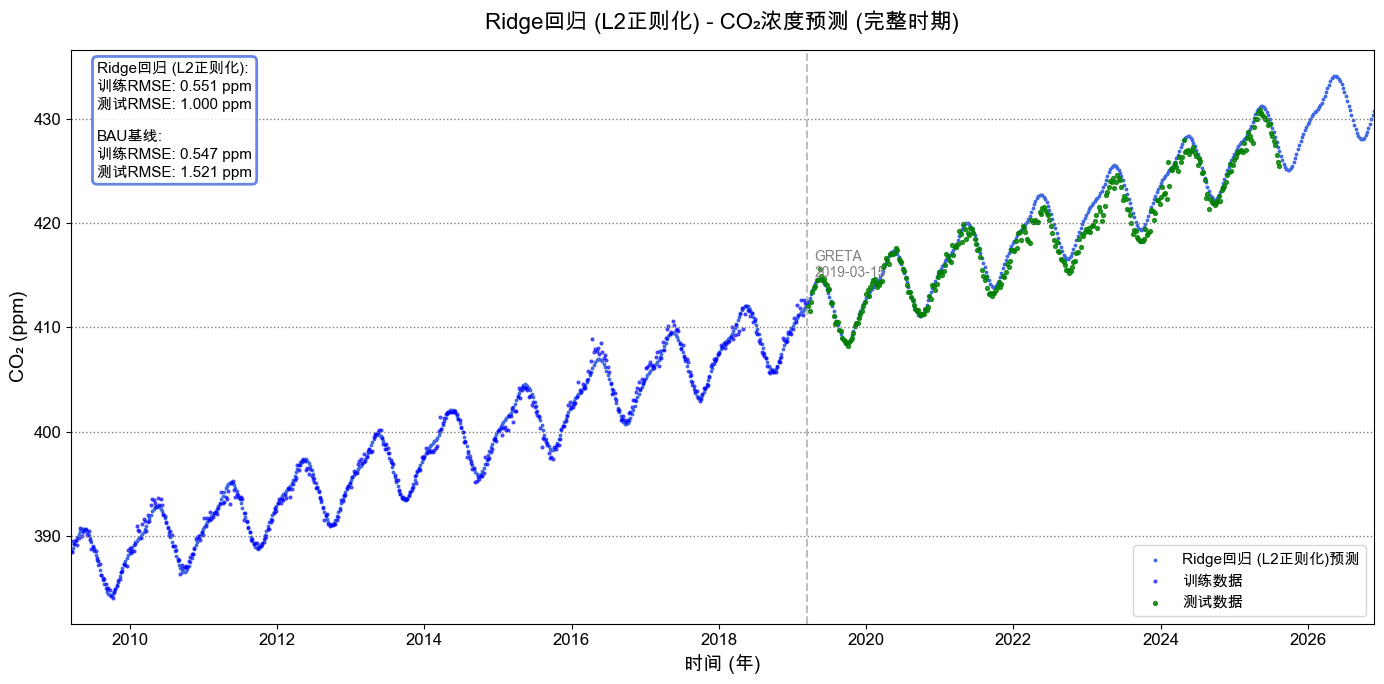

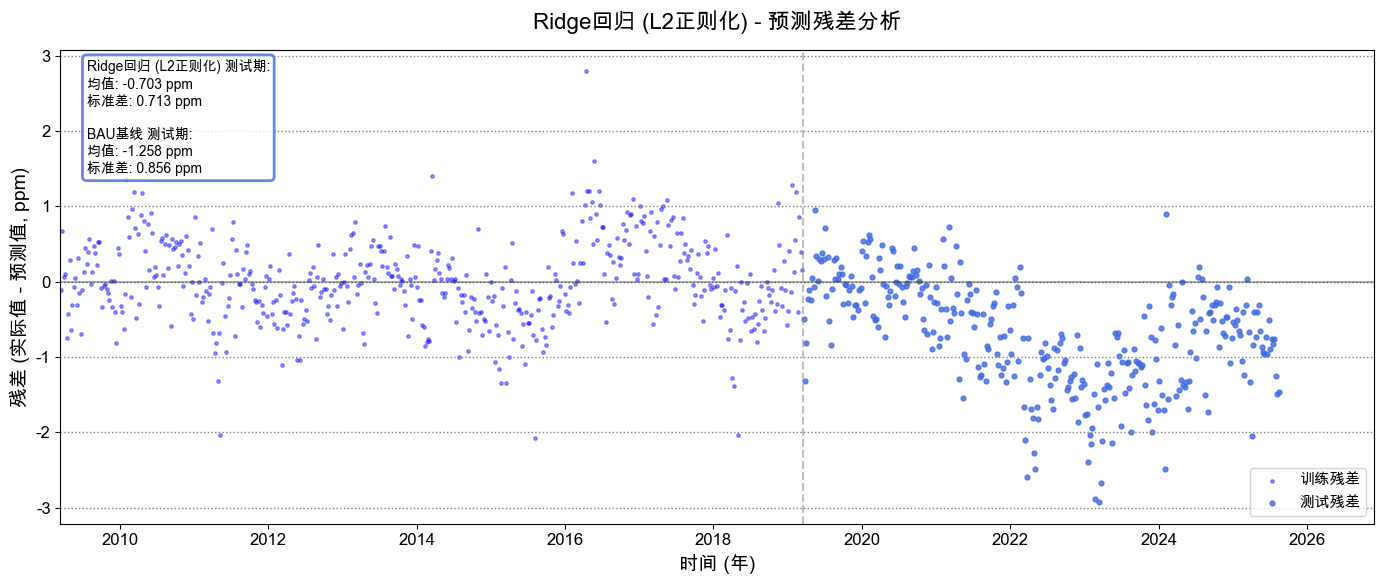

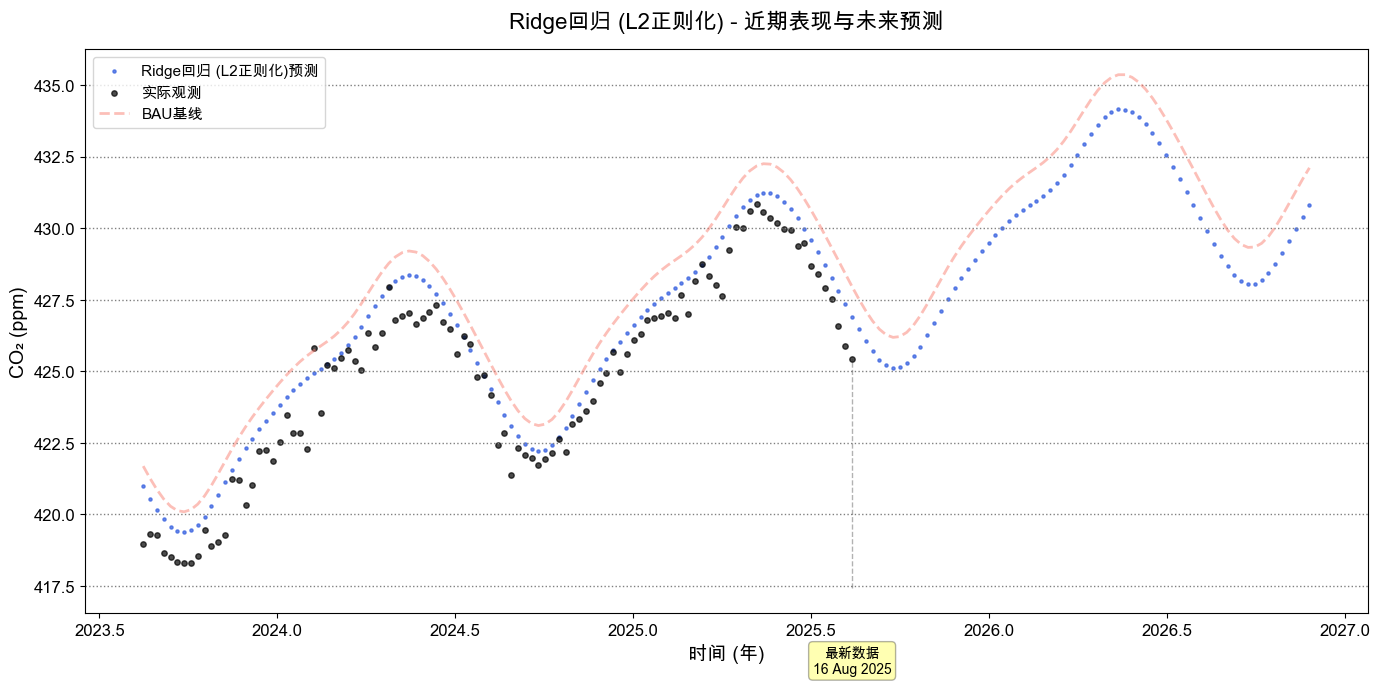


Ridge回归 (L2正则化) 可视化完成
Ridge回归 (L2正则化):
  训练期 RMSE: 0.5507 ppm
  测试期 RMSE: 1.0003 ppm
  测试期 平均残差: -0.7026 ppm

BAU基线（对比）:
  训练期 RMSE: 0.5470 ppm
  测试期 RMSE: 1.5208 ppm
  测试期 平均残差: -1.2582 ppm

改进程度:
  测试RMSE相比BAU: +34.2%



In [35]:
# Ridge回归详细可视化
plot_model_analysis('Ridge回归 (L2正则化)', 'Ridge_ppm', 'Ridge_resid', 
                   model_colors_dict['Ridge'], 'Ridge')



### Lasso回归模型分析


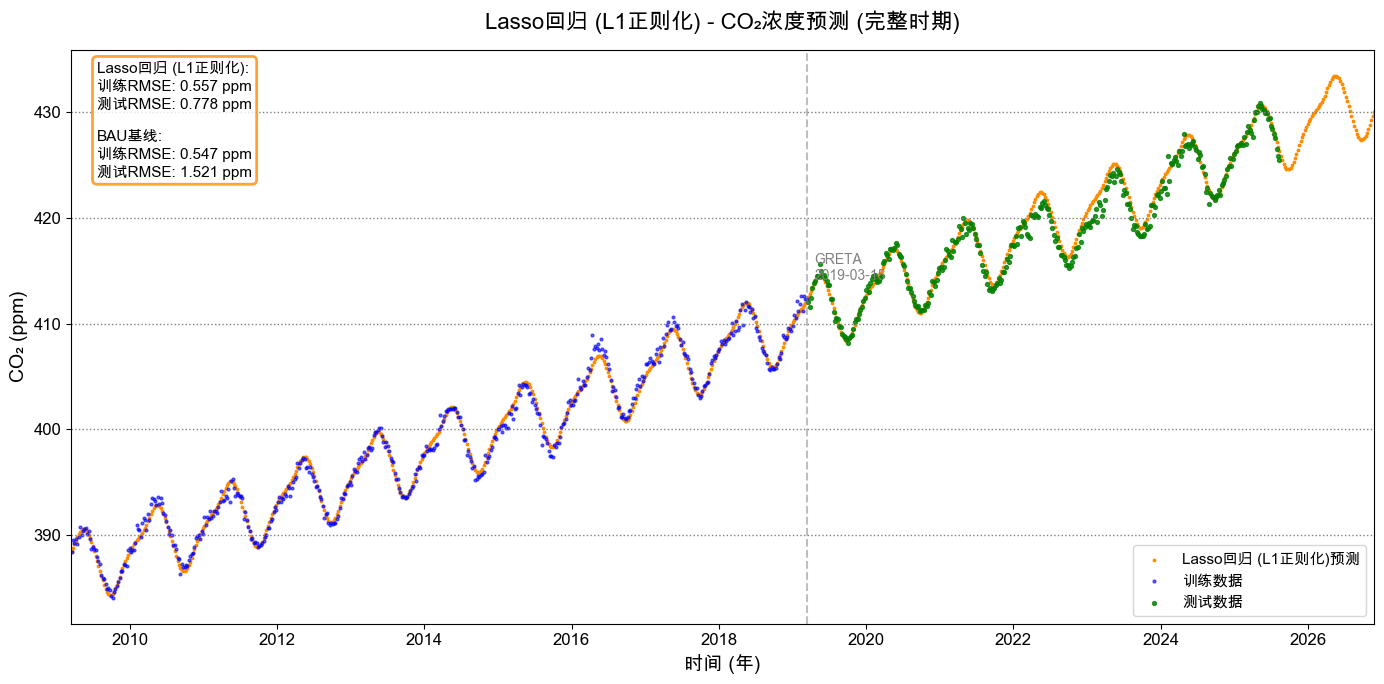

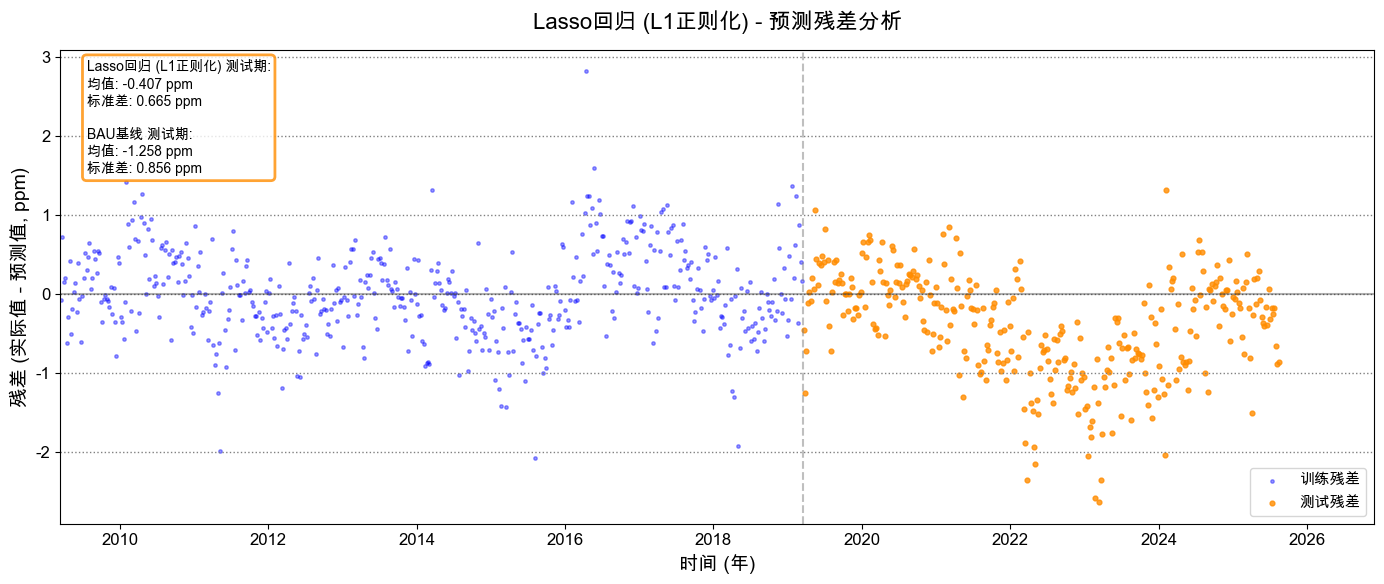

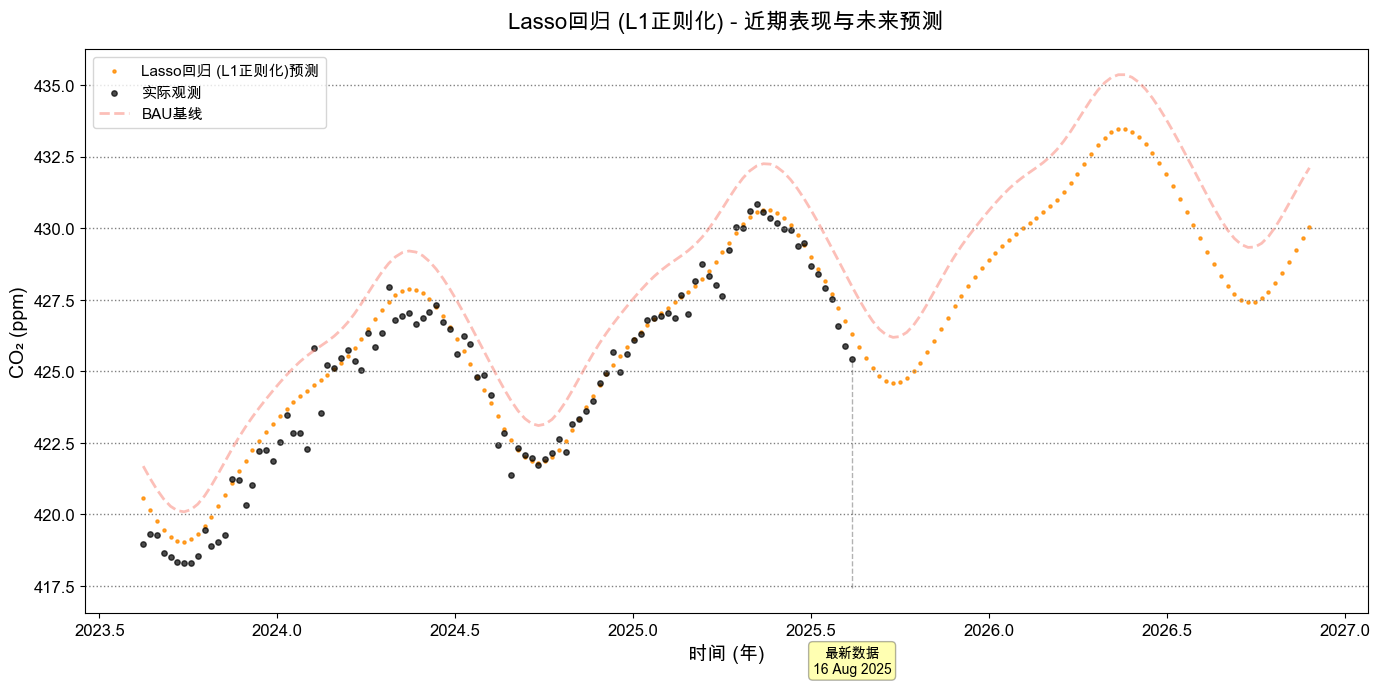


Lasso回归 (L1正则化) 可视化完成
Lasso回归 (L1正则化):
  训练期 RMSE: 0.5569 ppm
  测试期 RMSE: 0.7783 ppm
  测试期 平均残差: -0.4067 ppm

BAU基线（对比）:
  训练期 RMSE: 0.5470 ppm
  测试期 RMSE: 1.5208 ppm
  测试期 平均残差: -1.2582 ppm

改进程度:
  测试RMSE相比BAU: +48.8%



In [36]:
# Lasso回归详细可视化
plot_model_analysis('Lasso回归 (L1正则化)', 'Lasso_ppm', 'Lasso_resid',
                   model_colors_dict['Lasso'], 'Lasso')


### 梯度提升回归(GBR)模型分析


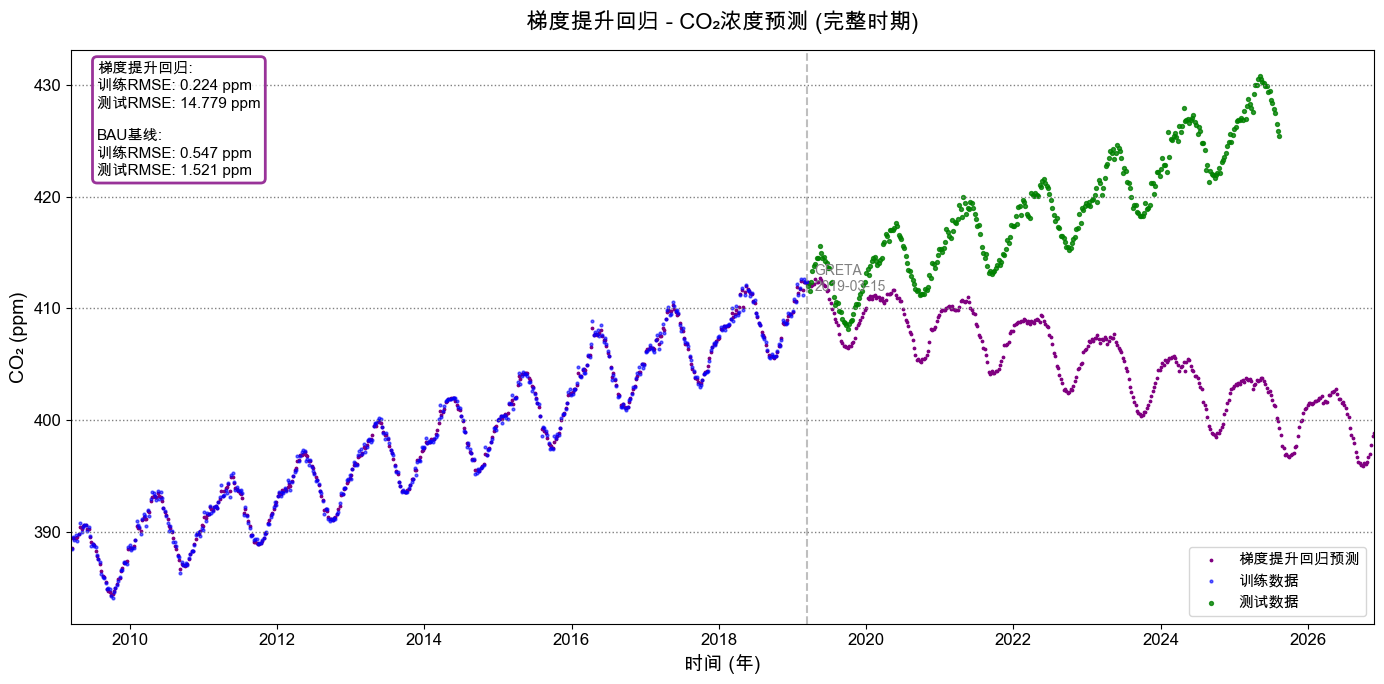

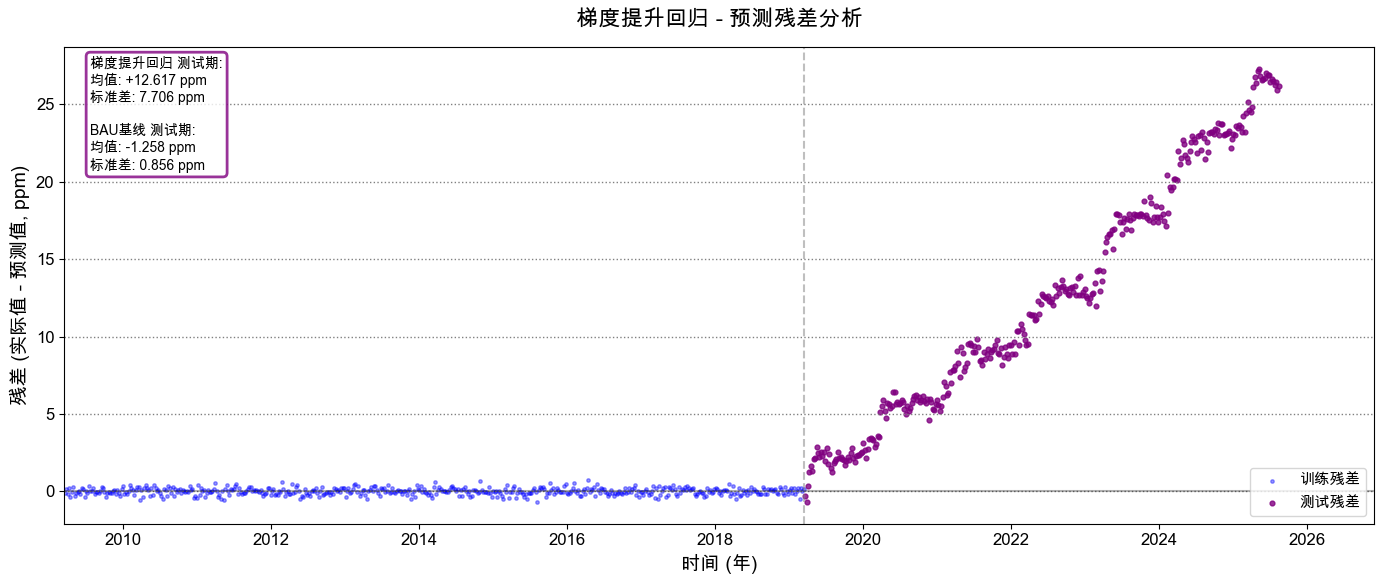

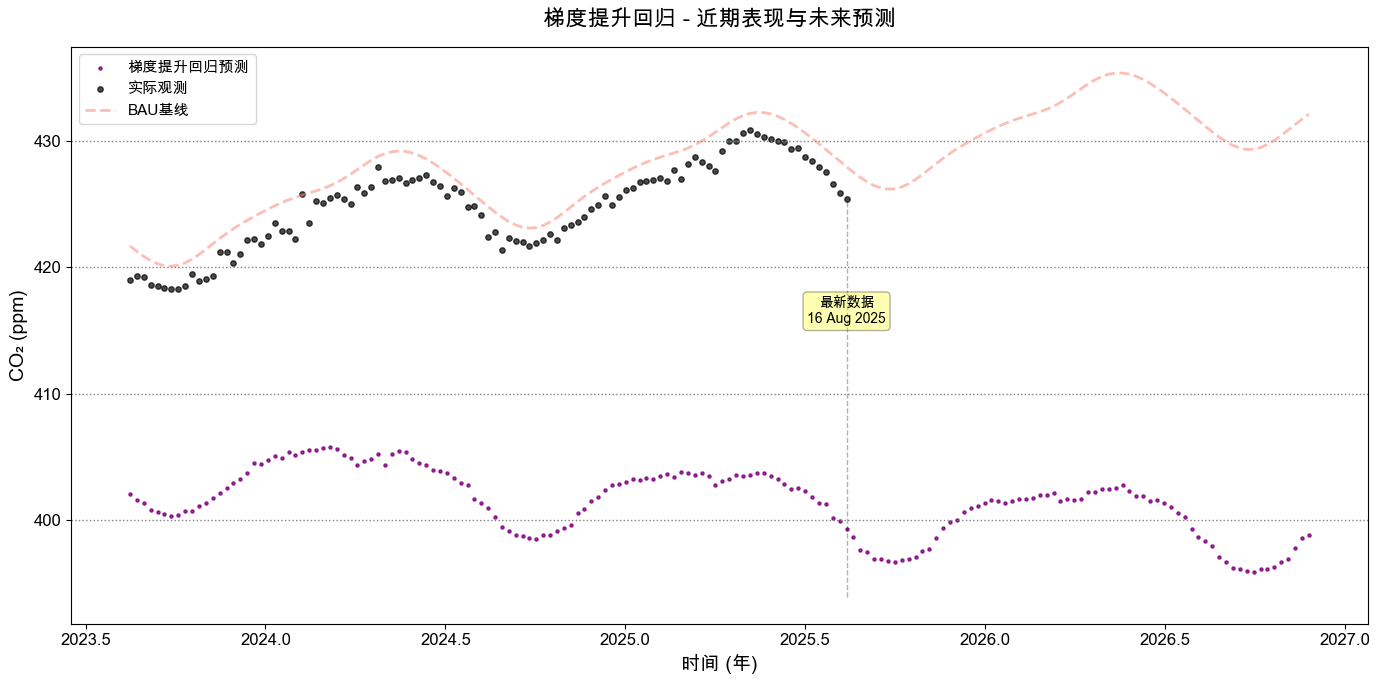


梯度提升回归 可视化完成
梯度提升回归:
  训练期 RMSE: 0.2235 ppm
  测试期 RMSE: 14.7786 ppm
  测试期 平均残差: +12.6172 ppm

BAU基线（对比）:
  训练期 RMSE: 0.5470 ppm
  测试期 RMSE: 1.5208 ppm
  测试期 平均残差: -1.2582 ppm

改进程度:
  测试RMSE相比BAU: -871.8%



In [37]:
# GBR详细可视化
plot_model_analysis('梯度提升回归', 'GBR_ppm', 'GBR_resid',
                   model_colors_dict['GBR'], 'GBR')


### 大语言模型(LLM)预测分析


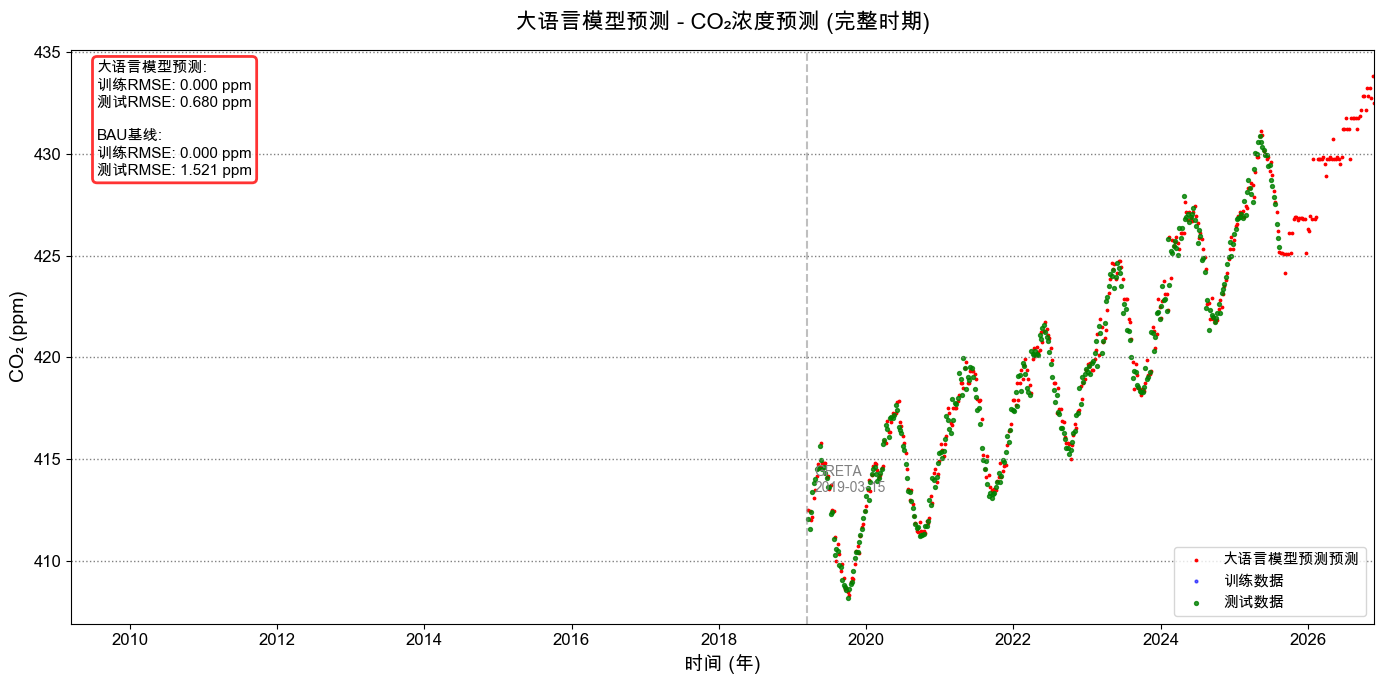

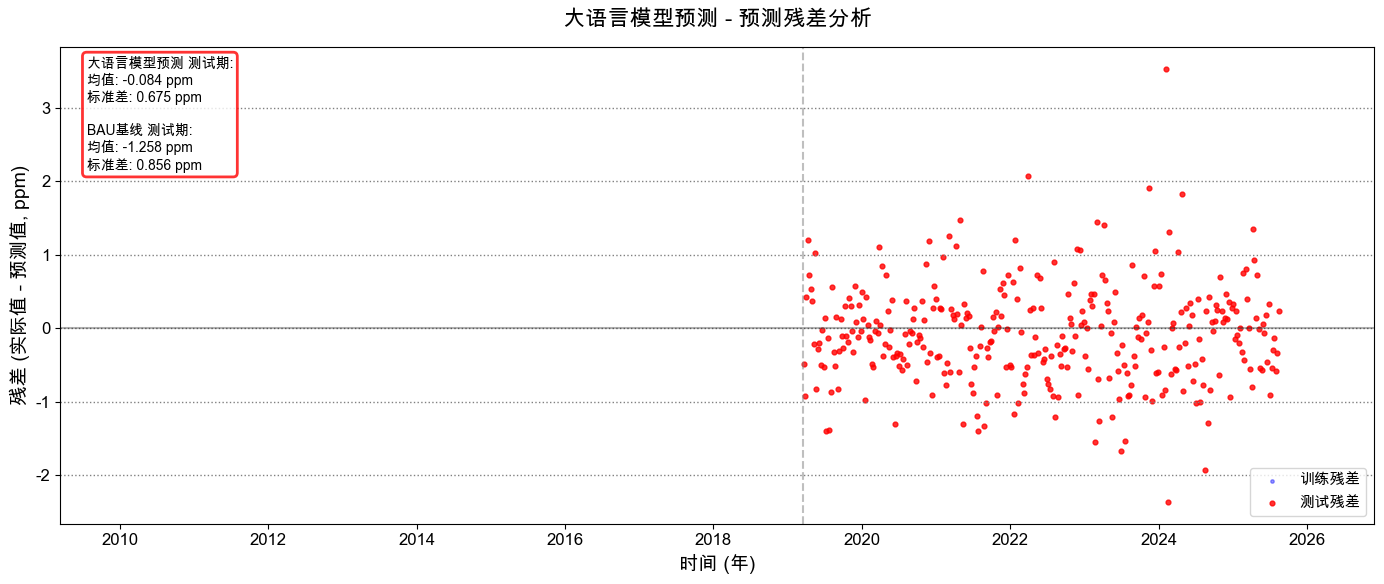

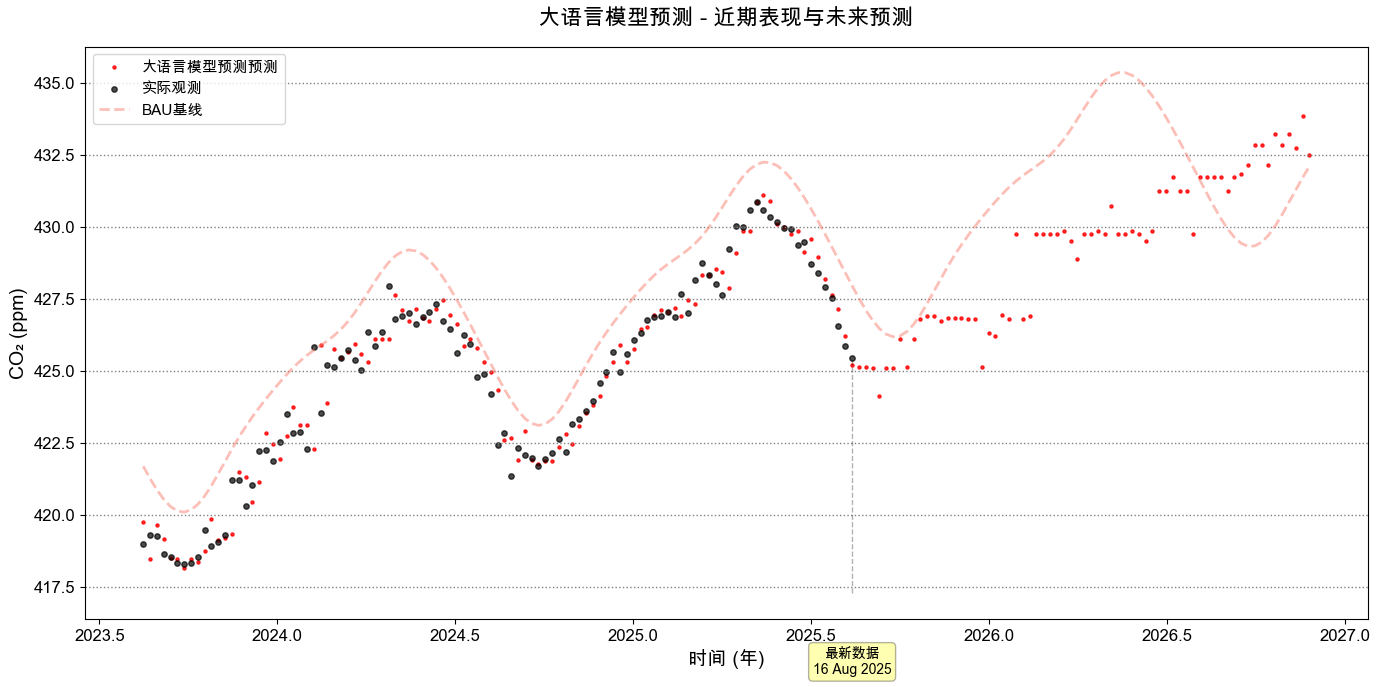


大语言模型预测 可视化完成
大语言模型预测:
  训练期 RMSE: 0.0000 ppm
  测试期 RMSE: 0.6796 ppm
  测试期 平均残差: -0.0840 ppm

BAU基线（对比）:
  训练期 RMSE: 0.0000 ppm
  测试期 RMSE: 1.5208 ppm
  测试期 平均残差: -1.2582 ppm

改进程度:
  测试RMSE相比BAU: +55.3%



In [38]:
# LLM详细可视化
plot_model_analysis('大语言模型预测', 'LLM_ppm', 'LLM_resid',
                   model_colors_dict['LLM'], 'LLM')


## 所有模型综合对比

将所有模型的可视化结果放在同一个图中进行对比分析


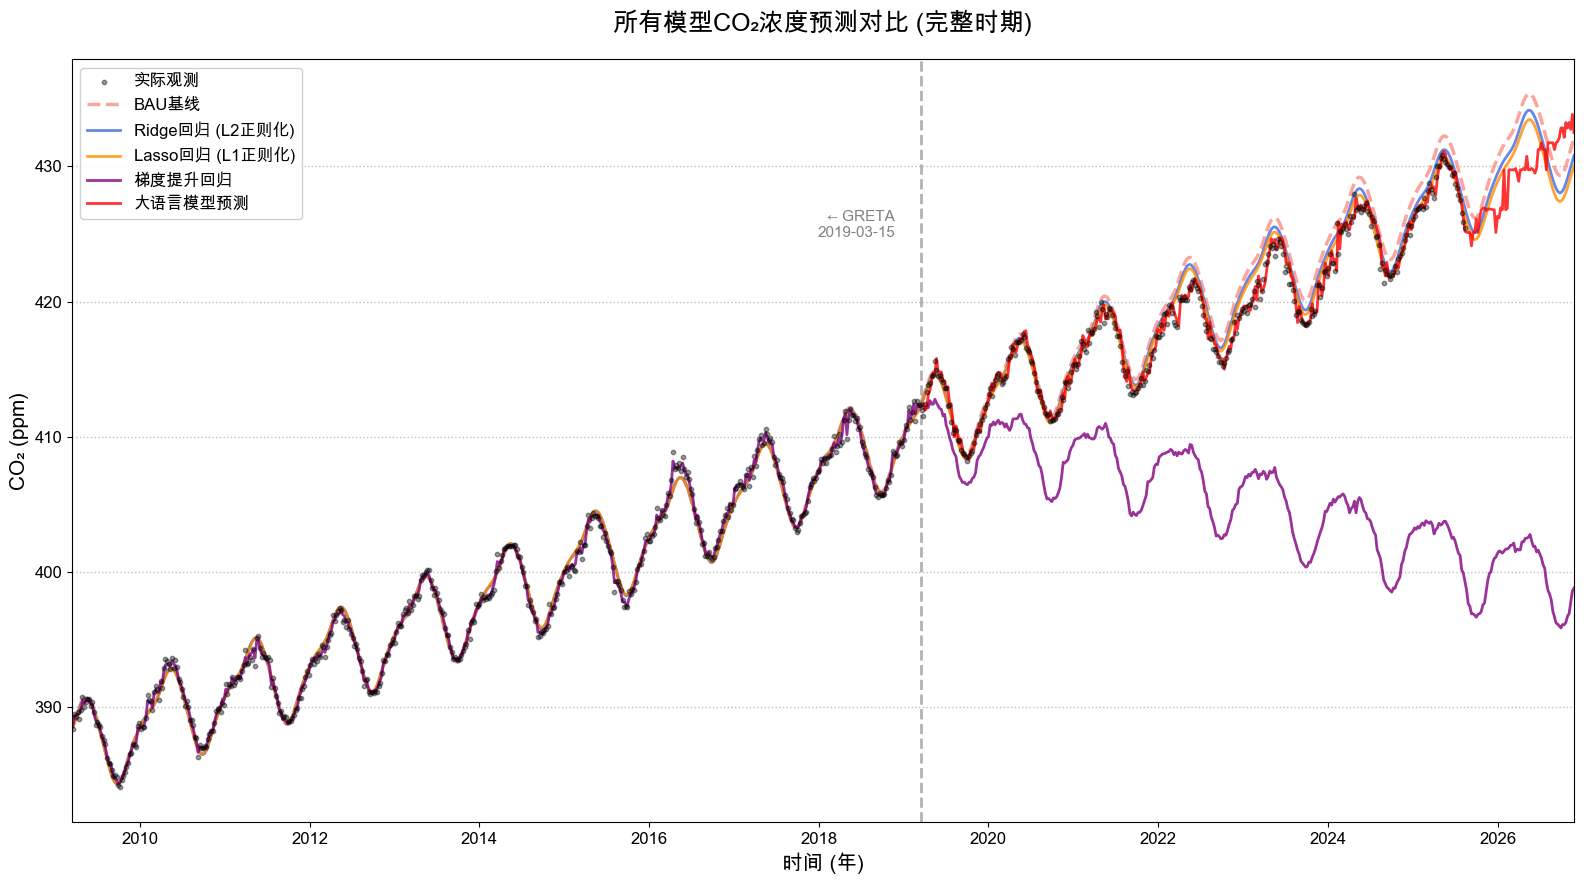

In [39]:
# === 综合对比图 1: 所有模型预测对比（完整时期）===
fig, ax = plt.subplots(figsize=(16, 9))

# 实际观测数据
valid_mask = df_co2['CO2_ppm'].notna()
df_co2[valid_mask].plot.scatter('time', 'CO2_ppm', c='black', s=10, 
                                alpha=0.4, ax=ax, label='实际观测', zorder=5)

# BAU模型（作为基线）
df_co2.plot('time', 'BAU_ppm', c=bau_model_clr, linewidth=2.5, 
           ax=ax, label='BAU基线', alpha=0.7, style='--')

# 其他所有模型
for model_key in ['Ridge', 'Lasso', 'GBR', 'LLM']:
    ppm_col = f'{model_key}_ppm'
    color = model_colors_dict[model_key]
    label = model_names_cn[model_key]
    df_co2.plot('time', ppm_col, c=color, linewidth=2, 
               ax=ax, label=label, alpha=0.8)

# 添加GRETA标记
plt.axvline(x=yr_GRETA, color='gray', linestyle='--', linewidth=2, alpha=0.6)
plt.text(yr_GRETA-0.3, plt.ylim()[1]*0.97, '← GRETA\n2019-03-15', 
        color='gray', fontsize=11, ha='right')

plt.grid(axis='y', color='gray', linestyle=':', linewidth=1, alpha=0.5)
plt.title('所有模型CO₂浓度预测对比 (完整时期)', fontsize=18, pad=20, fontweight='bold')
plt.ylabel('CO₂ (ppm)', fontsize=15)
plt.xlabel('时间 (年)', fontsize=15)
plt.xlim(yr_start, yr_end)

plt.legend(loc='upper left', fontsize=12, framealpha=0.9)
plt.tight_layout()
plt.savefig(f'CO2_AllModels_comparison_full_{co2_file_date}.png', dpi=150, bbox_inches='tight')
plt.show()


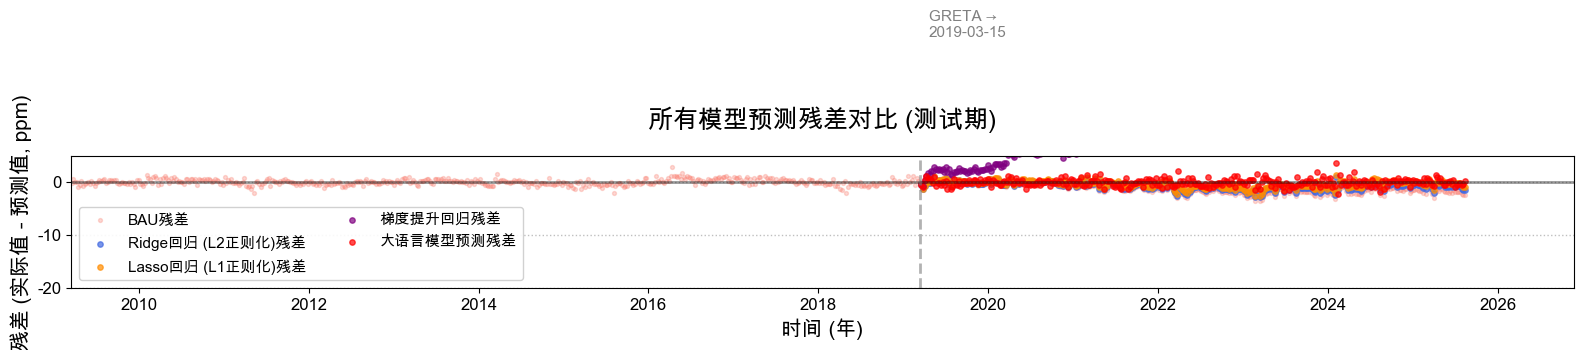

In [40]:
# === 综合对比图 2: 所有模型残差对比 ===
fig, ax = plt.subplots(figsize=(16, 8))

# 零线
plt.axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.4)

# BAU残差（基线）
df_co2.plot.scatter('time', 'BAU_resid', c=bau_model_clr, s=8, 
                   alpha=0.3, ax=ax, label='BAU残差')

# 所有模型的残差
test_mask = ~fit_rows & df_co2['CO2_ppm'].notna()
for model_key in ['Ridge', 'Lasso', 'GBR', 'LLM']:
    resid_col = f'{model_key}_resid'
    color = model_colors_dict[model_key]
    label = model_names_cn[model_key]
    df_co2[test_mask].plot.scatter('time', resid_col, c=color, s=15, 
                                   alpha=0.7, ax=ax, label=f'{label}残差')

# 添加GRETA标记
plt.axvline(x=yr_GRETA, color='gray', linestyle='--', linewidth=2, alpha=0.6)
plt.text(yr_GRETA+0.1, plt.ylim()[1]*0.95, 'GRETA →\n2019-03-15', 
        color='gray', fontsize=11)

plt.grid(axis='y', color='gray', linestyle=':', linewidth=1, alpha=0.5)
plt.title('所有模型预测残差对比 (测试期)', fontsize=18, pad=20, fontweight='bold')
plt.ylabel('残差 (实际值 - 预测值, ppm)', fontsize=15)
plt.xlabel('时间 (年)', fontsize=15)
plt.xlim(yr_start, yr_end)
plt.ylim(-20, 5)  # 调整以适应GBR的大残差

plt.legend(loc='lower left', fontsize=11, framealpha=0.9, ncol=2)
plt.tight_layout()
plt.savefig(f'CO2_AllModels_residuals_{co2_file_date}.png', dpi=150, bbox_inches='tight')
plt.show()


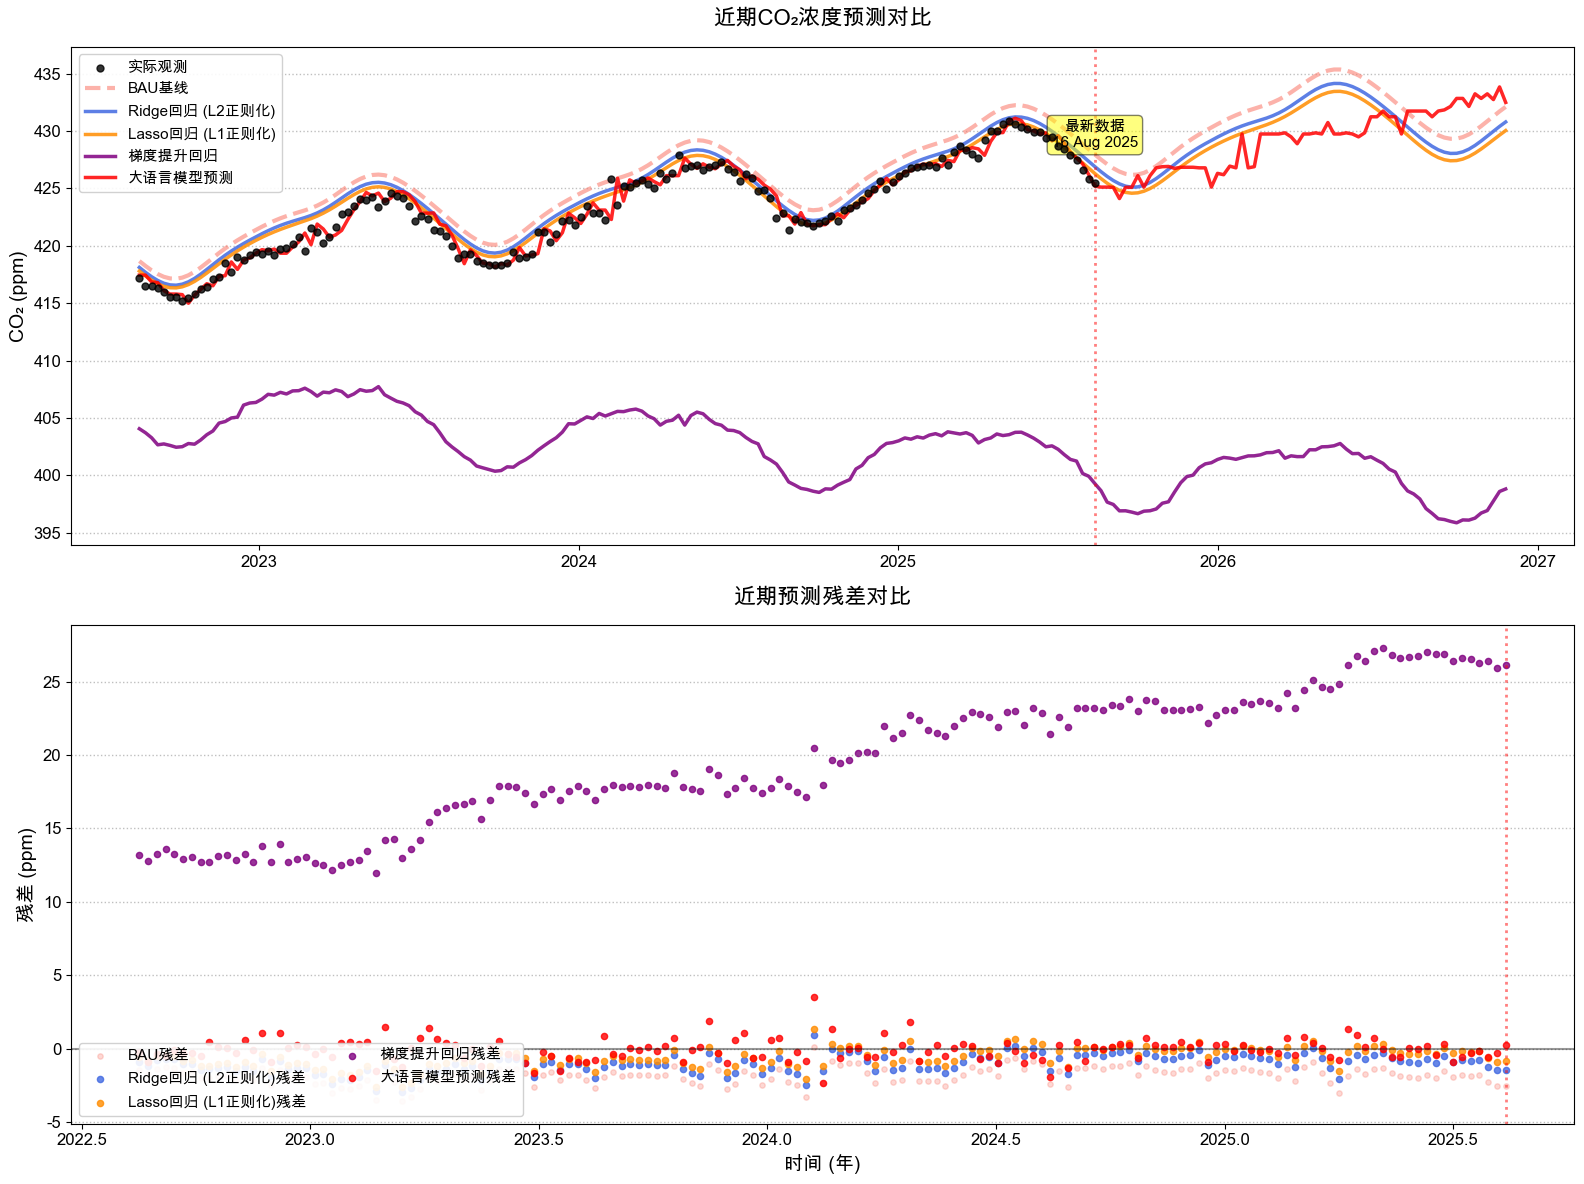

In [41]:
# === 综合对比图 3: 近期详细对比（最近3年 + 未来预测）===
yr_plt_start_recent = yr_newest - 3.0
yr_plt_stop_recent = yr_end

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

recent_mask = (df_co2['time'] > yr_plt_start_recent) & (df_co2['time'] < yr_plt_stop_recent)
obs_recent = recent_mask & df_co2['CO2_ppm'].notna()

# 子图1: PPM预测
# 实际观测
df_co2[obs_recent].plot.scatter('time', 'CO2_ppm', c='black', s=25, 
                               alpha=0.8, ax=ax1, label='实际观测', marker='o', zorder=10)

# BAU基线
df_co2[recent_mask].plot('time', 'BAU_ppm', c=bau_model_clr, linewidth=3, 
                        ax=ax1, label='BAU基线', alpha=0.6, style='--')

# 所有模型
for model_key in ['Ridge', 'Lasso', 'GBR', 'LLM']:
    ppm_col = f'{model_key}_ppm'
    color = model_colors_dict[model_key]
    label = model_names_cn[model_key]
    df_co2[recent_mask].plot('time', ppm_col, c=color, linewidth=2.5, 
                            ax=ax1, label=label, alpha=0.85)

# 标注最新数据点
ax1.axvline(x=yr_newest, color='red', linestyle=':', linewidth=2, alpha=0.5)
ax1.text(yr_newest, ax1.get_ylim()[1]*0.98, f'最新数据\n{co2_file_date_str}', 
        ha='center', fontsize=11, 
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

ax1.grid(axis='y', color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax1.set_title('近期CO₂浓度预测对比', fontsize=16, pad=15, fontweight='bold')
ax1.set_ylabel('CO₂ (ppm)', fontsize=14)
ax1.set_xlabel('')
ax1.legend(loc='upper left', fontsize=11, framealpha=0.9)

# 子图2: 残差
# 零线
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.4)

# BAU残差
df_co2[recent_mask].plot.scatter('time', 'BAU_resid', c=bau_model_clr, s=15, 
                                alpha=0.3, ax=ax2, label='BAU残差')

# 所有模型残差
for model_key in ['Ridge', 'Lasso', 'GBR', 'LLM']:
    resid_col = f'{model_key}_resid'
    color = model_colors_dict[model_key]
    label = model_names_cn[model_key]
    mask_with_data = recent_mask & df_co2[resid_col].notna()
    df_co2[mask_with_data].plot.scatter('time', resid_col, c=color, s=20, 
                                       alpha=0.8, ax=ax2, label=f'{label}残差')

# 标注最新数据点
ax2.axvline(x=yr_newest, color='red', linestyle=':', linewidth=2, alpha=0.5)

ax2.grid(axis='y', color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax2.set_title('近期预测残差对比', fontsize=16, pad=15, fontweight='bold')
ax2.set_ylabel('残差 (ppm)', fontsize=14)
ax2.set_xlabel('时间 (年)', fontsize=14)
ax2.legend(loc='lower left', fontsize=11, framealpha=0.9, ncol=2)

plt.tight_layout()
plt.savefig(f'CO2_AllModels_recent_comparison_{co2_file_date}.png', dpi=150, bbox_inches='tight')
plt.show()


所有模型性能汇总表

按测试RMSE排序:
             模型   训练RMSE    测试RMSE      测试均值    测试标准差      测试最小      测试最大  样本数
        大语言模型预测      NaN  0.679636 -0.084000 0.675434 -2.360000  3.530000  335
Lasso回归 (L1正则化) 0.556866  0.778282 -0.406688 0.664564 -2.638951  1.316675  335
Ridge回归 (L2正则化) 0.550658  1.000309 -0.702616 0.713068 -2.925657  0.948879  335
          BAU基线 0.547029  1.520792 -1.258184 0.855550 -3.568612  0.763903  335
         梯度提升回归 0.223545 14.778612 12.617242 7.706481 -0.690406 27.313887  335


/var/folders/bs/03qb0k5n4njfb9hjhdcv9p4m0000gn/T/ipykernel_47538/4279277381.py:134: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(models, rotation=15, ha='right')


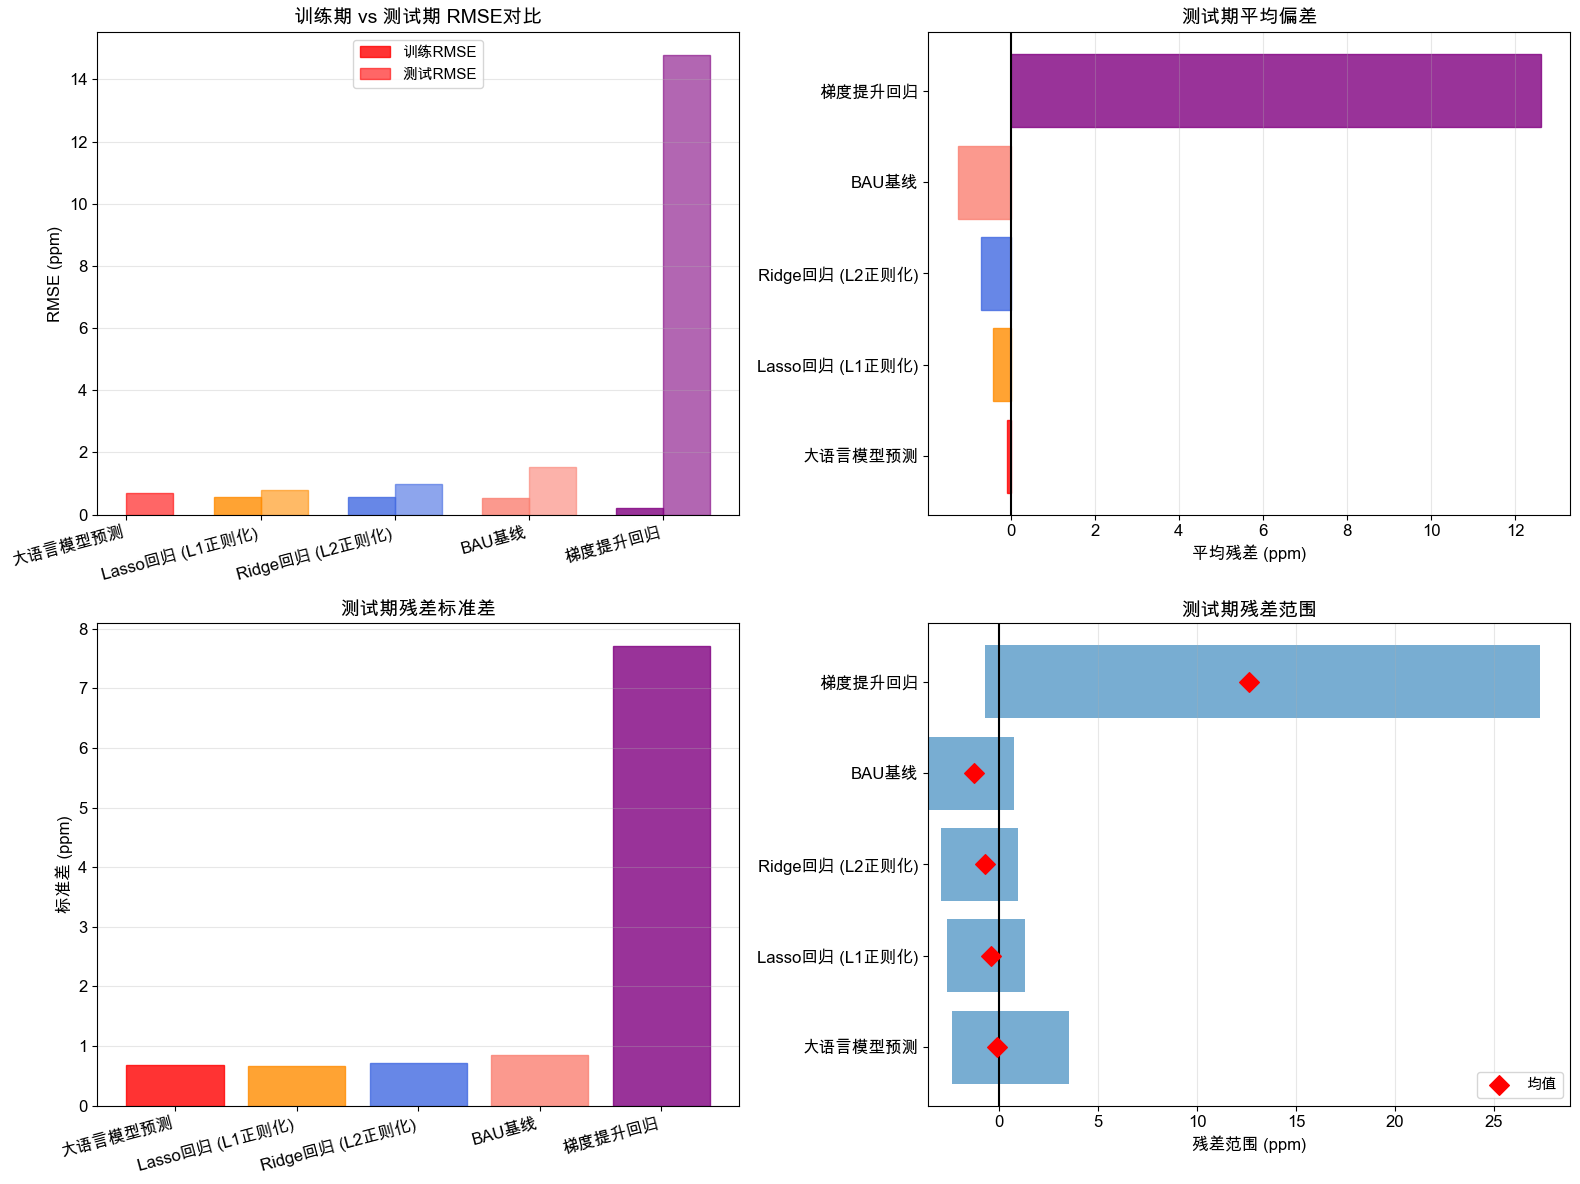


综合对比分析完成！


In [42]:
# === 性能汇总表 ===
print("="*80)
print("所有模型性能汇总表")
print("="*80)

# 计算所有模型的统计指标
models_summary = []

for model_key in ['BAU', 'Ridge', 'Lasso', 'GBR', 'LLM']:
    if model_key == 'BAU':
        ppm_col, resid_col = 'BAU_ppm', 'BAU_resid'
        model_name = 'BAU基线'
        color = bau_model_clr
    else:
        ppm_col = f'{model_key}_ppm'
        resid_col = f'{model_key}_resid'
        model_name = model_names_cn[model_key]
        color = model_colors_dict[model_key]
    
    # 计算训练期和测试期统计
    valid_mask = df_co2[ppm_col].notna() & df_co2['CO2_ppm'].notna()
    train_mask = fit_rows & valid_mask
    test_mask = (~fit_rows) & valid_mask
    
    train_resid = df_co2.loc[train_mask, resid_col]
    test_resid = df_co2.loc[test_mask, resid_col]
    
    if len(test_resid) > 0:
        models_summary.append({
            '模型': model_name,
            '训练RMSE': np.sqrt(np.mean(train_resid**2)) if len(train_resid) > 0 else np.nan,
            '测试RMSE': np.sqrt(np.mean(test_resid**2)),
            '测试均值': test_resid.mean(),
            '测试标准差': test_resid.std(),
            '测试最小': test_resid.min(),
            '测试最大': test_resid.max(),
            '样本数': len(test_resid)
        })

# 创建DataFrame并显示
summary_df = pd.DataFrame(models_summary)
summary_df = summary_df.sort_values('测试RMSE')

print("\n按测试RMSE排序:")
print(summary_df.to_string(index=False))

# 创建可视化的性能对比图
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

models = summary_df['模型'].values
colors = [bau_model_clr] + [model_colors_dict[k] for k in ['Lasso', 'Ridge', 'LLM', 'GBR'] 
          if any(models[i].startswith(model_names_cn[k][:4]) for i in range(len(models)))]

# 子图1: RMSE对比
x = np.arange(len(models))
train_rmse = summary_df['训练RMSE'].values
test_rmse = summary_df['测试RMSE'].values

width = 0.35
bars1 = ax1.bar(x - width/2, train_rmse, width, label='训练RMSE', alpha=0.8)
bars2 = ax1.bar(x + width/2, test_rmse, width, label='测试RMSE', alpha=0.8)

# 为每个柱子设置颜色
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    model_name = models[i]
    if 'BAU' in model_name:
        color = bau_model_clr
    elif 'Ridge' in model_name:
        color = model_colors_dict['Ridge']
    elif 'Lasso' in model_name:
        color = model_colors_dict['Lasso']
    elif 'GBR' in model_name or '梯度' in model_name:
        color = model_colors_dict['GBR']
    elif 'LLM' in model_name or '语言' in model_name:
        color = model_colors_dict['LLM']
    else:
        color = 'gray'
    bar1.set_color(color)
    bar2.set_color(color)
    bar2.set_alpha(0.6)

ax1.set_ylabel('RMSE (ppm)', fontsize=12)
ax1.set_title('训练期 vs 测试期 RMSE对比', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# 子图2: 测试期均值（偏差）
mean_resid = summary_df['测试均值'].values
bars = ax2.barh(models, mean_resid, alpha=0.8)
for i, bar in enumerate(bars):
    model_name = models[i]
    if 'BAU' in model_name:
        color = bau_model_clr
    elif 'Ridge' in model_name:
        color = model_colors_dict['Ridge']
    elif 'Lasso' in model_name:
        color = model_colors_dict['Lasso']
    elif 'GBR' in model_name or '梯度' in model_name:
        color = model_colors_dict['GBR']
    elif 'LLM' in model_name or '语言' in model_name:
        color = model_colors_dict['LLM']
    else:
        color = 'gray'
    bar.set_color(color)

ax2.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
ax2.set_xlabel('平均残差 (ppm)', fontsize=12)
ax2.set_title('测试期平均偏差', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 子图3: 测试期标准差
std_resid = summary_df['测试标准差'].values
bars = ax3.bar(models, std_resid, alpha=0.8)
for i, bar in enumerate(bars):
    model_name = models[i]
    if 'BAU' in model_name:
        color = bau_model_clr
    elif 'Ridge' in model_name:
        color = model_colors_dict['Ridge']
    elif 'Lasso' in model_name:
        color = model_colors_dict['Lasso']
    elif 'GBR' in model_name or '梯度' in model_name:
        color = model_colors_dict['GBR']
    elif 'LLM' in model_name or '语言' in model_name:
        color = model_colors_dict['LLM']
    else:
        color = 'gray'
    bar.set_color(color)

ax3.set_ylabel('标准差 (ppm)', fontsize=12)
ax3.set_title('测试期残差标准差', fontsize=14, fontweight='bold')
ax3.set_xticklabels(models, rotation=15, ha='right')
ax3.grid(axis='y', alpha=0.3)

# 子图4: 残差范围（箱线图风格）
ax4.barh(models, summary_df['测试最大'].values - summary_df['测试最小'].values, 
        left=summary_df['测试最小'].values, alpha=0.6)
ax4.scatter(summary_df['测试均值'].values, models, c='red', s=100, 
           zorder=5, marker='D', label='均值')
ax4.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
ax4.set_xlabel('残差范围 (ppm)', fontsize=12)
ax4.set_title('测试期残差范围', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'CO2_AllModels_performance_summary_{co2_file_date}.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("综合对比分析完成！")
print("="*80)


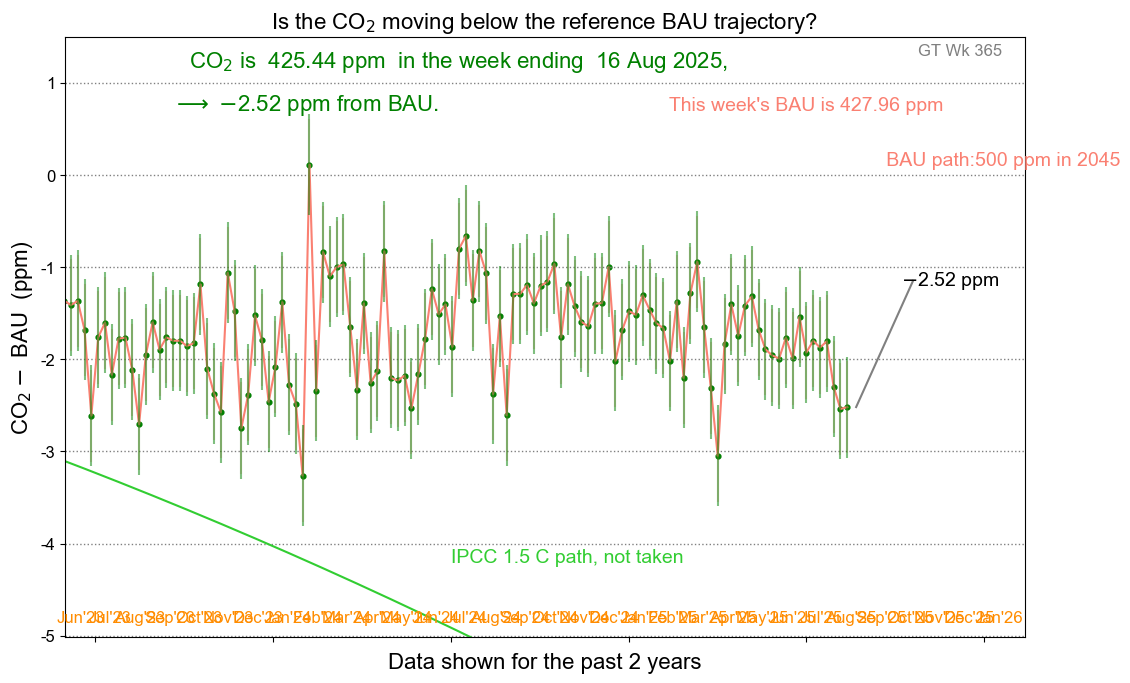

Most recent data point is ( 2025.62, 425.44 ) for GT week 365.
-2.52 ppm from current BAU (427.96).


In [43]:
# Simplified figure showing where we are compared to BAU and IPCC/SR15
# Plotted over the near past/future
# Strangely, * It seems too zoomed in to be useful? *
yr_plt_start = yr_newest - 1.5 - 0.7
yr_plt_stop = yr_newest + 0.7 - 0.2

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.figsize':(12,6)})
fig = plt.figure(1,facecolor='white')
ax = fig.add_axes([0.1, 0.1, 0.8, 1.0])

# Show the BaU model line with errors size indicated
df_co2.plot('time','BAU_resid',c=bau_model_clr,legend=None,
                    xlim=(yr_plt_start, yr_plt_stop),ylim=(-5.01,1.5),ax=ax)
df_co2.plot.scatter('time','BAU_resid',c=bau_model_clr,alpha=0.3,s=1,yerr=model_std,ax=ax)

# The IPCC SR15 model line:
df_co2.plot('time','SR15_resid',c=sr15_model_clr,legend=None,
                    xlim=(yr_plt_start, yr_plt_stop),ax=ax)


# data used for fitting (not in this range)
##df_co2[fit_rows].plot.scatter('time','CO2_resid',c=fit_data_clr,alpha=0.3,yerr=resid_std,s=1,ax=ax)
##df_co2[fit_rows].plot.scatter('time','CO2_resid',c=fit_data_clr,s=12, ax=ax)

# new data
df_co2[~fit_rows].plot.scatter('time','CO2_resid',c=new_data_clr,alpha=0.5,yerr=resid_std,s=1,ax=ax)
df_co2[~fit_rows].plot.scatter('time','CO2_resid',c=new_data_clr,s=12, ax=ax)

# Add month names in the previous 2, current, next years
y_months = -1.95 - 0.5 - 0.5 - 0.5 - 1.4  # location of the months labels
for year_offset in [-2,-1.0,0.0,1.0]:
    for imon, month in enumerate(months):
        x_month = int(yr_newest) + year_offset + 0.0417+imon/12.0
        if (x_month > (yr_plt_start + 0.0417)) and (x_month < (yr_plt_stop - 0.0417)):
            month_str = month+"'"+str(int(x_month-2000))
            plt.text(x_month, y_months, month_str, color=met_ppm_clr,
                horizontalalignment='center',fontsize=12)

# Label the most recent value:
annot_resid = -1.2
sign_str = "$+$"
if resid_newest < 0.0:
    sign_str = "$-$"
plt.text(yr_newest+0.40-0.25, annot_resid,"{}{:.2f} ppm".format(sign_str,abs(resid_newest)),
         color='black', fontsize=14)
plt.plot([yr_newest+0.025, yr_newest+0.40-0.015-0.2],
         [resid_newest,annot_resid+0.05],c="gray")

# Label with the key information
info_string = ("CO$_2$ is  {:.2f} ppm  in the week ending  ".format(ppm_newest) +
          co2_file_date_str+",")
plt.text(yr_newest - 1.85, 1.17, info_string, color=new_data_clr, fontsize=16)

# State the relation to BAU:
abovebelow = 'from'
rel_bau_string = ("$ \\longrightarrow $ "+sign_str+"{:.2f} ppm ".format(
                    abs(resid_newest)) + abovebelow + " BAU.")
plt.text(yr_newest - 1.90, 1.20 - 0.5, rel_bau_string, color=new_data_clr, fontsize=16)

# Include the GT week
plt.text( yr_newest+0.2, 1.30, "GT Wk {}".format(GTwk_newest),color='gray',fontsize=12)

# Current BAU ppm for reference
plt.text(yr_newest-0.5, 0.70, "This week's BAU is {:.2f} ppm".format(bau_newest),
         color=bau_model_clr, fontsize=14)

# Label the BAU and IPCC curves
plt.text(yr_newest+0.02, 0.10, "      BAU path:500 ppm in 2045",
         color=bau_model_clr, fontsize=14)
# Usually just manually adjust the annotation positions, but here for fun,
# adjust the y location based on where the IPCC curve leaves the plot:
sr15_at_end = df_co2['SR15_resid'].where(df_co2['time'] > yr_plt_stop).max()
# Nov, 2022: The IPCC curve is dropping and the data are not dropping with it  :(
plt.text(2024.5, -4.2, "IPCC 1.5 C path, not taken",
         color=sr15_model_clr, fontsize=14)


# Plot title
plt.title("Is the CO$_2$ moving below the reference BAU trajectory?", size=16)

# Plot grid and labels
plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)
plt.xlabel("Data shown for the past 2 years", size=16)
ax.set_xticklabels([])
plt.ylabel("CO$_2 -$ BAU  (ppm)", size=16)

plt.savefig("CO2headingto500ppm_simple_"+co2_file_date+".png", bbox_inches='tight')
plt.show()


# Repeat of the newest information after the plot
print("Most recent data point is ( "+
      "{:.2f}, {:.2f} ) for GT week {}.".format(yr_newest, ppm_newest, GTwk_newest))
print("{:.2f} ppm from current BAU ({:.2f}).".format(resid_newest,bau_newest))

In [44]:
# Can the covid effect be modelled as a region of decreasing ppm
# followed by a leveling off that continues parallel to BAU?
# Yes...
# Until Aug 2023 when it's pretty clear there is no leveling off
# but instead an increased slope returning toward the BAU path  :(
# So, include a slope after t2:
#
#              t1
# r1... _______
#              \
#               \       __--  <-- slope m2 after t2
#          r2... \__--
#                t2
#
# Fit this "shift + slope" function to the BAU residuals...
# 6 Jan 2025: modify the model to include a factor times the periodic component
# to see if its amplitude is changing, maybe a 3.5% decrease since 2021?

In [45]:
# The fit routines
from scipy.optimize import leastsq, curve_fit

# The fit function
def fit_shift(x,t1,r1,t2,r2,m2,peramp):
    # Function is constant r1 below t1,
    # r2 + m2(x-t2) above t2,
    # and varies linearly betweent1,r1 and t2,r2.
    out = 0.0*x
    deltat = t2 - t1
    deltar = r2 - r1
    for tj,tval in enumerate(x):
        ##print(tj, tval)
        out[tj] = r1
        if tval > t1:
            if tval > t2:
                out[tj] = r2 + m2*(tval - t2)
            else:
                out[tj] = r1 + (deltar)*(tval - t1)/deltat
    #
    #  --> Include a factor times the periodic component
    ##out += peramp*periodic_of_times(x)
    # Can apply it during select times, e.g., 
    #   between 2021 and 2023:
    ##out += peramp*(x > 2021.0)*(x < 2023.0)*periodic_of_times(x)    
    #   only after 2023: 
    out += peramp*(x > 2023.0)*periodic_of_times(x)
    # Or don't include the term with both of the lines commented out.
    return out

 Fit params: 2020.49, -0.24, 2023.05, -2.14, 0.25, -0.041


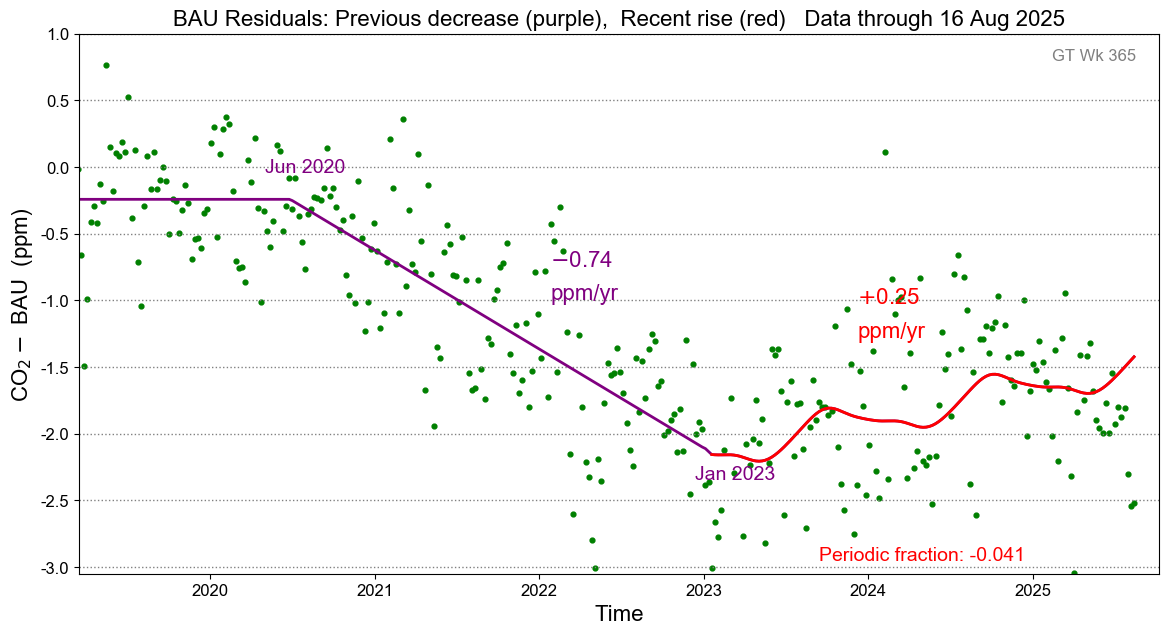

In [46]:
# Fit the shift function
# Use data from the first GRETA to the most recent value.
yr_plt_start = yr_fit  #yr_GRETA
yr_plt_stop = yr_newest + 0.001

# Select the values to fit
times = df_co2[(df_co2.time > yr_plt_start) & 
               (df_co2.time < yr_plt_stop)].time.values
resids = df_co2[(df_co2.time > yr_plt_start) & 
                (df_co2.time < yr_plt_stop)].CO2_resid.values

# Do the fit:
t1,r1,t2,r2,m2,peramp = curve_fit(fit_shift, times, resids,
             bounds=([2019.50, -1.0,     2020.0, -3.0,  -0.5,  -0.1],
                     [2021.50,  1.0,  yr_newest,  1.0,   4.0,   0.1] ))[0]

print(" Fit params: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.3f}".
      format(t1,r1,t2,r2,m2,peramp))

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.figsize':(12,6)})
fig = plt.figure(1,facecolor='white')
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])

df_co2.plot.scatter('time','CO2_resid',legend=None,
                    xlim=(yr_plt_start, yr_plt_stop+0.15),
                    ylim=(-3.05,1.0),c=new_data_clr,s=12, ax=ax)

fitshift = fit_shift(times, t1,r1,t2,r2,m2,peramp)
clr_fitshift = "purple"
plt.plot(times, fitshift,linewidth=2,color=clr_fitshift)

# emphasize the recent increase
seltimes = times > t2
plt.plot(times[seltimes],fitshift[seltimes],linewidth=2,color="red")

# # Show the begin/end dates of the shift
plt.text(t1-0.15, r1+0.20,months[int(12*(t1-int(t1)))]+" {}".format(int(t1)), color=clr_fitshift, size=14)
plt.text(t2-0.10, r2-0.20,months[int(12*(t2-int(t2)))]+" {}".format(int(t2)), color=clr_fitshift, size=14)

# Show the before/after ppm fit levels - or not: distracting from the ppm/yr values
##plt.text(t1-0.20, r1+0.20,"$-${:.2f} ppm".format(abs(r1)), color="blue", size=14)
##plt.text(t2-0.20, r2-0.20,"$-${:.2f} ppm".format(abs(r2)), color="blue", size=14)

# Label the "COVID" residual slope
plt.text(0.5*(t1+t2)+0.3, r1-0.50,"$-${:.2f}".format(abs((r2-r1)/(t2-t1))),
                         color=clr_fitshift, size=16)
plt.text(0.5*(t1+t2)+0.3, r1-0.75,"ppm/yr",color=clr_fitshift, size=16)

# Label the recent residual slope
mid_slope = (t2 + yr_newest)/2.0 - 0.4
plt.text(mid_slope, fitshift[-1]+0.40,"$+${:.2f}".format(m2),color="red", size=16)
plt.text(mid_slope, fitshift[-1]+0.15,"ppm/yr",color="red", size=16)

# If the periodic amplitude term is included, show its value:
if np.abs(peramp) > 0.005:
    plt.text(2023.7, -2.95, "Periodic fraction: {:.3f}".format(peramp),color="red",size=14)
    
# Include the GT week
plt.text( yr_newest-0.50, 0.80, "GT Wk {}".format(GTwk_newest),color='gray',fontsize=12)

# Kaggle notebook url
plt.text(yr_plt_start + 0.05, -2.65, " ",
         fontsize=12, color="gray")

# Plot title
plt.title("BAU Residuals: Previous decrease ("+clr_fitshift+"), " +
          " Recent rise (red)" +
          "   Data through "+co2_file_date_str, size=16)
# Plot grid and labels
plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)
plt.xlabel("Time", size=16)
plt.ylabel("CO$_2 -$ BAU  (ppm)", size=16)
plt.savefig("CO2headingto500ppm_shift_"+co2_file_date+".png", bbox_inches='tight')
plt.show()


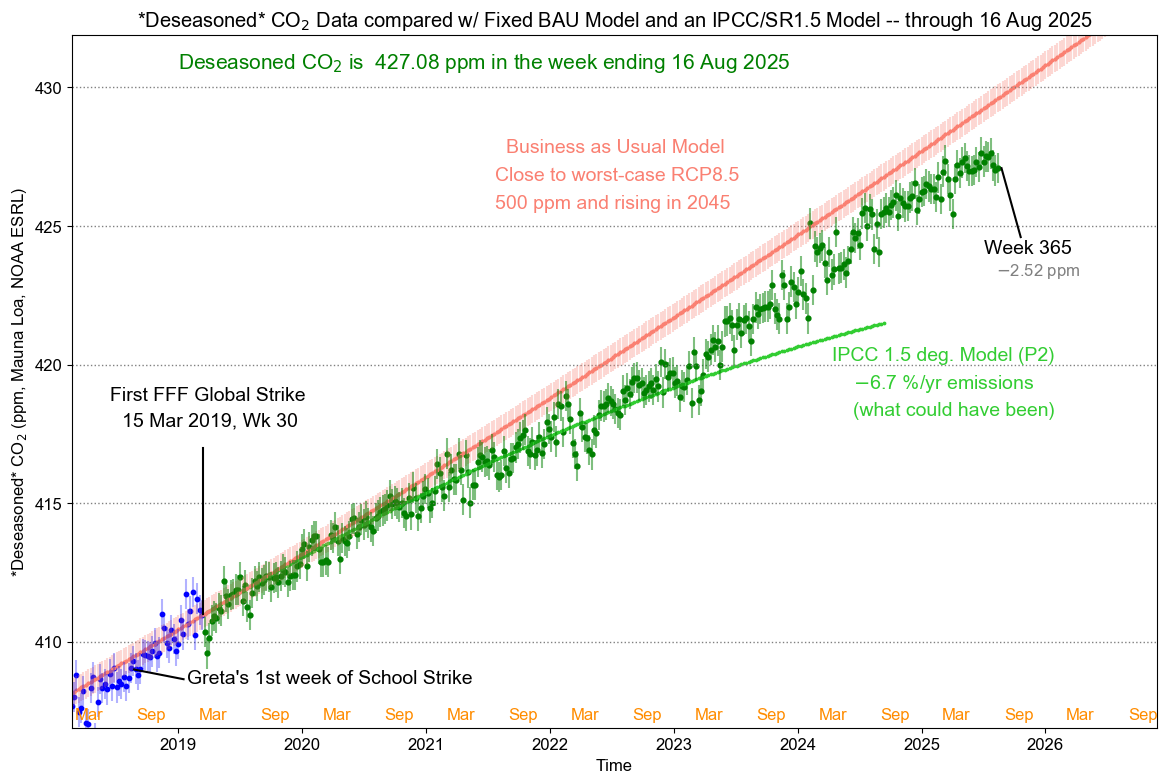

In [47]:
# - - - - -
#
# DE-SEASONED version
#
# This plot focusses on the recent past and future year or so...
# Include labels for significant events.

# Starting and stopping years on plot
yr_plt_start = yr_GTwk1  - 0.5 # Start relative to Greta's first school strike
yr_plt_stop = yr_end

# Model and Data, ppm values 
# show the BAU model and set the y-axis limits 
ax = df_co2.plot.scatter('time','BAU_secular',c=bau_model_clr,s=3,figsize=(14,9),
                         xlim=(yr_plt_start,yr_plt_stop), 
                         ylim=(406.9, 431.9))
# with error bars
df_co2.plot.scatter('time','BAU_secular',c=bau_model_clr,alpha=0.3,s=1,yerr=model_std,ax=ax)

# data used for fitting ( pre-GRETA)
df_co2[fit_rows].plot.scatter('time','CO2_secular',c=fit_data_clr,alpha=0.3,yerr=resid_std,s=1,ax=ax)
df_co2[fit_rows].plot.scatter('time','CO2_secular',c=fit_data_clr,s=10,ax=ax)

# Post-GRETA (aka new era) data, w/errors
df_co2[~fit_rows].plot.scatter('time','CO2_secular',c=new_data_clr,alpha=0.5,yerr=resid_std,s=1, ax=ax)
df_co2[~fit_rows].plot.scatter('time','CO2_secular',c=new_data_clr,s=12, ax=ax)

# The IPCC SR15 full model
df_co2[~fit_rows].plot.scatter('time','SR15_secular',c=sr15_model_clr,s=3,ax=ax)
# put BAU on top
df_co2.plot.scatter('time','BAU_secular',c=bau_model_clr,s=3,ax=ax)

# Add Mar, Sep month names in the years
for iyear in range(2018,2026+1):
    imon = 3-1; month = "Mar"
    plt.text(iyear+0.0+imon/12.0, 407.2, month,color=met_ppm_clr)
    imon = 9-1; month = "Sep"
    plt.text(iyear+0.0+imon/12.0, 407.2, month,color=met_ppm_clr)
    
# show grid(s)?
plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)

# title and axis labels
plt.title("*Deseasoned* CO$_2$ Data compared w/ Fixed BAU Model" +
         " and an IPCC/SR1.5 Model -- through "+co2_file_date_str)

plt.ylabel("*Deseasoned* CO$_2$ (ppm, Mauna Loa, NOAA ESRL)")
plt.xlabel("Time")


# Label with the key information
ppm_dseas = 430.7
info_string = ("Deseasoned CO$_2$ is  {:.2f} ppm in the week ending ".format(secular_newest) +
          co2_file_date[:-7]+" "+co2_file_date[-7:-4]+" "+co2_file_date[-4:])
plt.text(2019.0, ppm_dseas, info_string, color=new_data_clr, fontsize=15)


# Current GT week:   move this now and then
ppm_label = 424.0
yr_label = 2025.5
# line segment to it and text
plt.plot([yr_newest+0.03, yr_label+0.30],[secular_newest-0.0, ppm_label+0.60],c="black")
plt.text(yr_label, ppm_label,"Week {}".format(GTwk_newest),
         fontsize=14, color='black')
# include the ppm residual-from-BAU value:
sign_str = "$+$"
if resid_newest < 0.0:
    sign_str = "$-$"
plt.text(yr_label+0.10, ppm_label-0.80, "{}{:.2f} ppm".format(sign_str,abs(resid_newest)),
         fontsize=12, color='gray')

# GT week 1
plt.plot([yr_GTwk1,yr_GTwk1+0.4],[409,408.65],c="black")
plt.text(yr_GTwk1+0.40+0.03, 408.5,"Greta's 1st week of School Strike", fontsize=14, color="black")

# The GRETA location
plt.plot([yr_GRETA,yr_GRETA],[411.0, 417.0],c="black")
plt.text(yr_GRETA-0.75, 416.0+2.70,"First FFF Global Strike",color="black",fontsize=14)
plt.text(yr_GRETA-0.65, 416.0+1.80,"15 Mar 2019, Wk 30", color="black",fontsize=14)


# Annotation text for the data, model, etc.
# BAU information
describe_bau(0.40, 0.830, ax)
# IPCC SR15 information
describe_sr15(0.70, 0.53, ax)    

# Kaggle notebook url
plt.text(2022.3, 409.3, " ",
         fontsize=12, color="gray")

plt.savefig("CO2headingto500ppm_weeks_deseason_"+co2_file_date+".png", bbox_inches='tight')
plt.show()


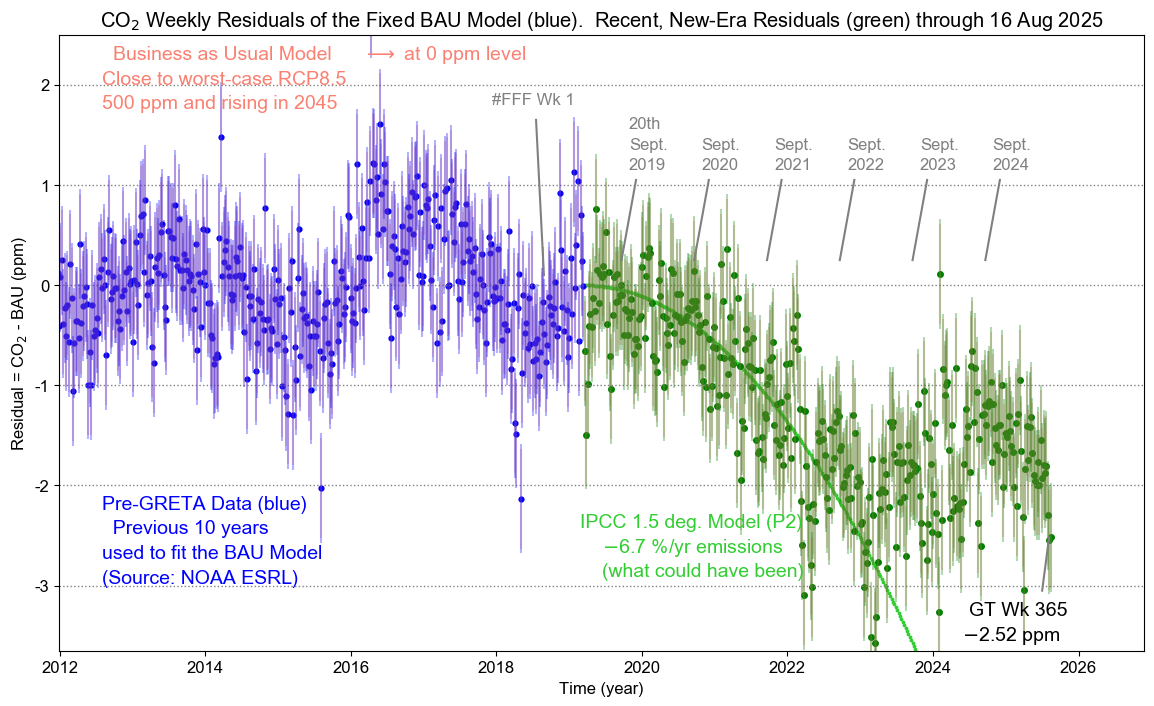

In [48]:
# - - - - -
# Model and Data RESIDUALS

# start full 10 years pre-GRETA:
yr_plt_start = 2011.99
# end the plot at:
yr_plt_stop = yr_end

# show the BAU model's residuals curve (=0) and error bars
ax = df_co2.plot.scatter('time','BAU_resid',c=bau_model_clr,s=3, figsize=(14,8),
                        xlim=(yr_plt_start,yr_plt_stop), ylim=(-3.65,2.5))
df_co2.plot.scatter('time','BAU_resid',c=bau_model_clr,alpha=0.3,s=1,yerr=model_std,ax=ax)

# Residual curve for SR15 model:
df_co2[~fit_rows].plot.scatter('time','SR15_resid',c=sr15_model_clr,s=3,ax=ax)
# Put BAU on top
df_co2.plot.scatter('time','BAU_resid',c=bau_model_clr,s=3,ax=ax)
                    
# data used for fitting, w errors
df_co2[fit_rows].plot.scatter('time','CO2_resid',c=fit_data_clr,alpha=0.3,yerr=resid_std,s=1,ax=ax)
df_co2[fit_rows].plot.scatter('time','CO2_resid',c=fit_data_clr,s=12, ax=ax)

# new data, w errors
df_co2[~fit_rows].plot.scatter('time','CO2_resid',c=new_data_clr,alpha=0.3,yerr=resid_std,s=1,ax=ax)
df_co2[~fit_rows].plot.scatter('time','CO2_resid',c=new_data_clr,s=16, ax=ax)

# show grid(s)?
plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)

# title
plt.title("CO$_2$ Weekly Residuals of the Fixed BAU Model ("+fit_data_clr+"). " +
         " Recent, New-Era Residuals ("+new_data_clr+") through "+co2_file_date_str)

plt.ylabel("Residual = CO$_2$ - BAU (ppm)")
plt.xlabel("Time (year)")

# Most recent data point
plt.plot([yr_newest-0.02, 2025.50], [resid_newest, -3.05], c='gray')
plt.text(2024.5, -3.30, "GT Wk {}".format(GTwk_newest),color='black',fontsize=14)
# include the ppm residual value from BaU:
sign_str = "$+$"
if resid_newest < 0.0:
    sign_str = "$-$"
plt.text(2024.5-0.10, -3.30-0.25, "{}{:.2f} ppm".format(sign_str,abs(resid_newest)),
         color='black',fontsize=14)

# school strike week 1
plt.text(yr_GTwk1-0.7, 1.8,"#FFF Wk 1", color="gray")
plt.plot([yr_GTwk1-0.1, yr_GTwk1+0.008],[1.65,0.1],c="gray")

# GRETA-General (with Adults)
# 2019 and future minima in Sept:
plt.text(yr_GRETA_General+0.1, 1.56,"20th", color="gray")
for yr_sept in [0,1,2,3,4, 5]:
    plt.plot([yr_GRETA_General+yr_sept,yr_GRETA_General+0.2+yr_sept],[0.25,1.05],c="gray")
    plt.text(yr_GRETA_General+0.1+yr_sept, 1.36,"Sept.", color="gray")
    plt.text(yr_GRETA_General+0.1+yr_sept, 1.16,str(2019+yr_sept), color="gray")

# Annotation text for the data, model, etc.
# Pre-GRETA data used for fitting BAU
describe_fit_data(0.040, 0.23, ax)
# BAU information
describe_bau(0.05, 0.96, ax)
plt.text(0.28, 0.96, "$ \\longrightarrow $ at 0 ppm level",
         color=bau_model_clr, transform=ax.transAxes, fontsize=14)
# IPCC SR15 information
describe_sr15(0.48, 0.20, ax) 

# Kaggle kernel
plt.text(yr_plt_start+0.30, -3.3, "", color="gray")

plt.savefig("CO2headingto500ppm_resids_"+co2_file_date+".png", bbox_inches='tight')
plt.show()

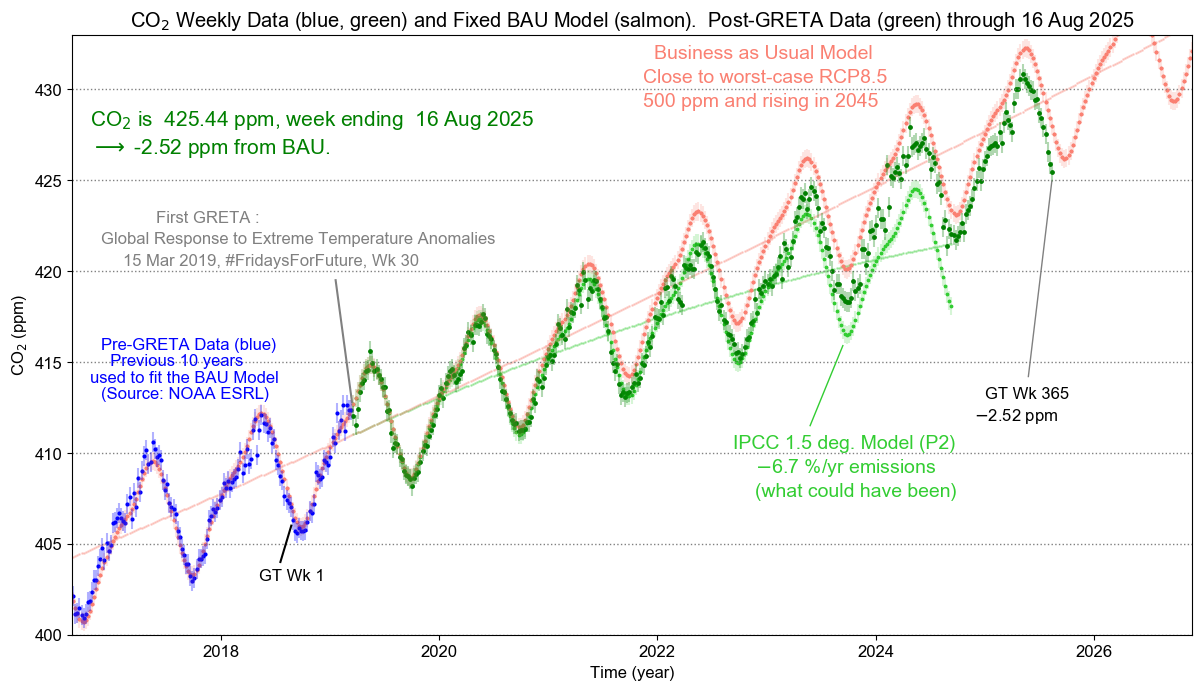

In [49]:
# - - - - -
# Larger-range view of CO2 values
# 

# start 2 years before school strike week 1:
yr_plt_start = yr_GTwk1 - 3.5/DAYS_YR - 2.0
yr_plt_stop = yr_end

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.figsize':(14,6)})
fig = plt.figure(1,facecolor='white')
ax = fig.add_axes([0.1, 0.1, 0.8, 1.0])


df_co2.plot.scatter('time','BAU_ppm',c=bau_model_clr,s=3,
                        xlim=(yr_plt_start,yr_plt_stop), 
                        ylim=(400.0, 433.0),ax=ax)
# The SR15 secular trend
df_co2[~fit_rows].plot.scatter('time','SR15_secular',c=sr15_model_clr,s=1,ax=ax, alpha=0.3)
# The SR15 full model
df_co2[~fit_rows].plot.scatter('time','SR15_ppm',c=sr15_model_clr,s=1,alpha=0.2,ax=ax,yerr=model_std)
df_co2[~fit_rows].plot.scatter('time','SR15_ppm',c=sr15_model_clr,s=3,ax=ax)
# BAU on top
df_co2.plot.scatter('time','BAU_secular',c=bau_model_clr,s=1,ax=ax, alpha=0.3)
df_co2.plot.scatter('time','BAU_ppm',c=bau_model_clr,s=1,alpha=0.2,ax=ax,yerr=model_std)
df_co2.plot.scatter('time','BAU_ppm',c=bau_model_clr,s=3,ax=ax)

# data used for fitting
df_co2[fit_rows].plot.scatter('time','CO2_ppm',c=fit_data_clr,alpha=0.3,yerr=resid_std,s=1,ax=ax)
df_co2[fit_rows].plot.scatter('time','CO2_ppm',c=fit_data_clr,s=4,ax=ax)

# new data
df_co2[~fit_rows].plot.scatter('time','CO2_ppm',c=new_data_clr,s=1, yerr=resid_std,alpha=0.3, ax=ax)
df_co2[~fit_rows].plot.scatter('time','CO2_ppm',c=new_data_clr,s=6, ax=ax)

# Label with current CO2 value
info_string = ("CO$_2$ is  {:.2f} ppm, week ending  ".format(ppm_newest) +
          co2_file_date[:-7]+" "+co2_file_date[-7:-4]+" "+co2_file_date[-4:])
plt.text(2016.80, 428.00, info_string, color=new_data_clr, fontsize=15)
# State the relation to BAU:
abovebelow = 'from'
rel_bau_string = ("$ \\longrightarrow $ {:.2f} ppm ".format(resid_newest) + 
                  abovebelow + " BAU.")
plt.text(2016.80, 428.0-1.5, rel_bau_string, color=new_data_clr, fontsize=15)

# current GT week:
plt.plot([yr_newest, 2025.4],[ppm_newest-0.5,414.2],linewidth=1,c="gray")
plt.text(2025.0, 413.0, "GT Wk {}".format(GTwk_newest), color='black') #color=new_data_clr)
sign_str = "$+$"
if resid_newest < 0.0:
    sign_str = "$-$"
plt.text(2025.2-0.3, 413-1.2,"{}{:.2f} ppm".format(sign_str,abs(resid_newest)),
         color='black') #color=new_data_clr)

# Data fit for prediction
plt.text(2016.9, 415.7, "Pre-GRETA Data ("+fit_data_clr+")",color=fit_data_clr)
plt.text(2016.9, 415.7-0.9, "  Previous {} years".format(int(0.50+yr_fit - yr_start)),color=fit_data_clr)
plt.text(2016.9-0.1, 415.7-1.8, "used to fit the BAU Model",color=fit_data_clr)
plt.text(2016.9, 415.7-2.7, "(Source: NOAA ESRL)",color=fit_data_clr)

# GT week 1
plt.plot([yr_GTwk1-0.10,yr_GTwk1],[404,406],c="black")
plt.text(yr_GTwk1-0.30, 403.0,"GT Wk 1", color="black")

# The GRETA location
plt.plot([yr_GRETA,yr_GRETA-0.15],[412.8, 420.0-0.5],c="gray")
plt.text(yr_GRETA-1.8, 420.0+2.70,"First GRETA :",color="gray")
plt.text(yr_GRETA-2.3, 420.0+1.50,"Global Response to Extreme Temperature Anomalies",color="gray")
plt.text(yr_GRETA-2.1, 420.0+0.30,"15 Mar 2019, #FridaysForFuture, Wk 30", color="gray")



# show grid(s)?
plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)
plt.ylabel("CO$_2$ (ppm)")
plt.xlabel("Time (year)")
##plt.title("CO$_2$ Weekly Data and Fixed Future Models." +
##         "  Post-GRETA Data ("+new_data_clr+") through "+co2_file_date)
plt.title("CO$_2$ Weekly Data ("+fit_data_clr+", "+new_data_clr+") and Fixed BAU Model ("+bau_model_clr+"). " +
         " Post-GRETA Data ("+new_data_clr+") through "+co2_file_date_str)

# Annotation text for the data, model, etc.
# BAU information
describe_bau(0.52, 0.96, ax)
# IPCC SR15 information
describe_sr15(0.59, 0.31, ax)
plt.plot([2023.40,2023.70],[411.5,415.9],linewidth=1,c=sr15_model_clr)

# Kaggle kernel
plt.text(2021.1, 400.7, " ", color="gray")

plt.savefig("CO2headingto500ppm_future_"+co2_file_date+".png", bbox_inches='tight')
plt.show()


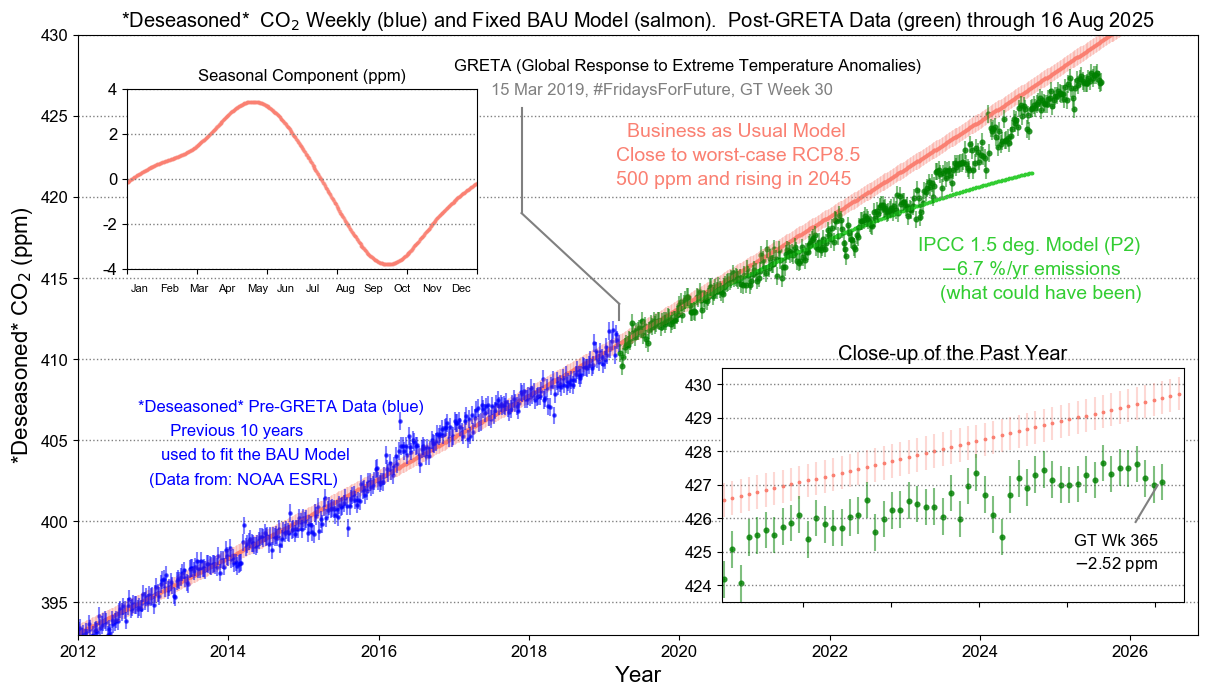

In [50]:
# - - - - -
# *Deseasoned* versions of the Model and Data,
# very boring but does show how little change to the BAU trajectory there has been.
# Try adding insert plots to make it more interesting and useful...
# Want mostly to emphasize how consistant the BaU has been.

# year range for the plot:
# Show all the BAU data that is fit
yr_plt_start = 2012.0 #yr_start
# and go 5 years purther
yr_plt_stop = yr_end

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.figsize':(14,6)})
fig = plt.figure(1,facecolor='white')
ax = fig.add_axes([0.1, 0.1, 0.8, 1.0])

# show the model
df_co2.plot.scatter('time','BAU_secular',c=bau_model_clr,s=3,
                        xlim=(yr_plt_start,yr_plt_stop), ylim=(393.0, 430.0),ax=ax)
df_co2.plot.scatter('time','BAU_secular',c=bau_model_clr,alpha=0.3,s=1,yerr=model_std,ax=ax)

# data used for fitting
df_co2[fit_rows].plot.scatter('time','CO2_secular',c=fit_data_clr,alpha=0.5,yerr=resid_std,s=1,ax=ax)
df_co2[fit_rows].plot.scatter('time','CO2_secular',c=fit_data_clr,alpha=0.5,s=6, ax=ax)

# new data
df_co2[~fit_rows].plot.scatter('time','CO2_secular',c=new_data_clr,alpha=0.5,yerr=resid_std,s=1,ax=ax)
df_co2[~fit_rows].plot.scatter('time','CO2_secular',c=new_data_clr,alpha=0.7,s=12, ax=ax)

# The SR15 secular trend
df_co2[~fit_rows].plot.scatter('time','SR15_secular',c=sr15_model_clr,s=3,ax=ax)
# BAU on top
df_co2.plot.scatter('time','BAU_secular',c=bau_model_clr,s=3,ax=ax)

# show grid(s)?
plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)
#
plt.title("*Deseasoned*  CO$_2$ Weekly ("+fit_data_clr+") and Fixed BAU Model ("+bau_model_clr+"). " +
         " Post-GRETA Data ("+new_data_clr+") through "+co2_file_date_str)
plt.ylabel("*Deseasoned* CO$_2$ (ppm)",size=16)
plt.xlabel("Year",size=16)

# Data fit for prediction
plt.text(2012.8, 406.8, "*Deseasoned* Pre-GRETA Data ("+fit_data_clr+")",color=fit_data_clr)
plt.text(2012.8+0.3, 405.3, "  Previous {} years".format(int(0.50+yr_fit - yr_start)),color=fit_data_clr)
plt.text(2012.8+0.3, 403.8, "used to fit the BAU Model",color=fit_data_clr)
plt.text(2012.8+0.15, 402.3, "(Data from: NOAA ESRL)",color=fit_data_clr)

# The GRETA location
plt.plot([2017.9, 2017.9], [419.0, 425.5], c="gray")
plt.plot([yr_GRETA, 2017.9], [413.4, 419.0], c="gray")
plt.plot([yr_GRETA, yr_GRETA], [413.4, 412.4], c="gray")
plt.text(2017.0, 427.8,"GRETA (Global Response to Extreme Temperature Anomalies)",color="black")
plt.text(2017.0+0.5, 426.3,"15 Mar 2019, #FridaysForFuture, GT Week 30", color="gray")

# BAU information
describe_bau(0.49, 0.83, ax)
# IPCC SR15 information
describe_sr15(0.75, 0.64, ax)

# Kaggle kernel
plt.text(2013.7, 393.6, " ", color="gray")


# _ _ _
# Add an inset figure -- Seasonal Variation
# params are [left, bottom, width, height] in fractions of figure size 
ax = fig.add_axes([0.135, 0.71, 0.25, 0.3])
df_co2.plot.scatter('yr_phase','BAU_periodic',c=bau_model_clr,alpha=0.35,s=3,
                        xlim=(0.0,1.0), ylim=(-4,4),ax=ax)
##df_co2.plot.scatter('yr_phase','BAU_periodic',c=bau_model_clr,alpha=0.10,s=1,yerr=model_std,ax=ax)
plt.xlabel("")
ax.set_xticklabels([])
plt.ylabel("")
plt.title("Seasonal Component (ppm)",size=12)
plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)
# Add month names
for imon, month in enumerate(months):
    plt.text(0.01+imon/12.0, -5.0, month,color='black',size=8)


# _ _ _
# Add an inset figure -- Close-up
# params are [left, bottom, width, height] in fractions of figure size 
ax = fig.add_axes([0.56, 0.155, 0.33, 0.39])
# show the model
df_co2.plot.scatter('time','BAU_secular',c=bau_model_clr,s=3,
                        xlim=(yr_newest-1.00, yr_newest+0.05), 
                        ylim=(423.5,430.5),ax=ax)
df_co2.plot.scatter('time','BAU_secular',c=bau_model_clr,alpha=0.3,s=1,yerr=model_std,ax=ax)
# data used for fitting
df_co2[fit_rows].plot.scatter('time','CO2_secular',c=fit_data_clr,alpha=0.5,yerr=resid_std,s=1,ax=ax)
df_co2[fit_rows].plot.scatter('time','CO2_secular',c=fit_data_clr,alpha=0.5,s=6, ax=ax)
# new data
df_co2[~fit_rows].plot.scatter('time','CO2_secular',c=new_data_clr,alpha=0.5,yerr=resid_std,s=1,ax=ax)
df_co2[~fit_rows].plot.scatter('time','CO2_secular',c=new_data_clr,alpha=0.7,s=12, ax=ax)
# The SR15 secular trend
df_co2[~fit_rows].plot.scatter('time','SR15_secular',c=sr15_model_clr,s=3,ax=ax)
#
# current GT week:
plt.text(yr_newest-0.20, secular_newest-1.9,"GT Wk {}".format(GTwk_newest), color='black')  #new_data_clr)
plt.plot([yr_newest-0.01, yr_newest-0.06],[secular_newest-0.10,secular_newest-1.2],c="gray")
# include the ppm residual value from BaU:
sign_str = "$+$"
if resid_newest < 0.0:
    sign_str = "$-$"
plt.text(yr_newest-0.20, secular_newest-2.6, "{}{:.2f} ppm".format(sign_str,abs(resid_newest)),
         color='black')  #new_data_clr)
#
plt.grid(axis='y', color='gray', linestyle=':', linewidth=1)
plt.xlabel("")
ax.set_xticklabels([])
plt.ylabel("")
plt.title("Close-up of the Past Year")


plt.savefig("CO2headingto500ppm_future_deseason_"+co2_file_date+".png", bbox_inches='tight')
plt.show()

# Summary and Report
This notebook processes NOAA Mauna Loa weekly CO$_2$ data for cleaning, decomposition, and modeling, and provides analysis and policy implications.
The content is compact and reproducible.
- Presented in Notebook form; all charts and Markdown are reproducible.
- Data processing and analysis steps are implemented in code cells.
- The report explains results with necessary background and uncertainty discussion.

## Background and Problem Statement
- Goal: assess whether atmospheric CO$_2$ is heading toward 500 ppm and estimate timelines under scenarios.
- Data: NOAA Mauna Loa weekly CO$_2$; train BAU baseline on 2009??2018, then compare 2023??2025 observations.
- Method: construct secular trend (ppm/yr) and acceleration (ppm/yr/yr) plus 1??5 harmonic seasonal terms.
- Scenario comparison: IPCC SR15 (e.g., P2) aligned at 2019-03-15 for trajectory comparison.
- Metric: residual vs BAU (ppm), check persistence below/above BAU.
- Communication: charts and narrative, automation-friendly for tools.

## Key Findings and Observations
- Source data: Mauna Loa Weekly CO$_2$; cleaned and used for fitting and prediction.
- Seasonal amplitude is about -4 ppm.
- Imputed missing/abnormal points and smoothed to obtain stable trend/seasonal components.
- BAU vs SR15: BAU baseline trained on 2009-C2018/2019; SR15 aligned at 2019-03-15; observations after 2023 test deviation.
- 2020??2022 shows a temporary dip (likely COVID-related), but growth clearly resumes after 2023.
- Latest residual relative to BAU secular component is about +2.52 ppm, indicating above-BAU conditions.
- A shift + slope fit to BAU residuals shows no sustained leveling; growth strengthens post-2023.
- Including the newest weeks keeps the secular trend pointing upward.
- SR15 low-carbon pathway is not being followed in recent observations.
- If BAU continues, a trend reference suggests ~2045 near 500 ppm (not a strict forecast).

## Methods and Steps
- Read text via `pandas.read_csv`, unify fields and dates, and build time + seasonal features.
- Set analysis end year `yr_end`, provide reproducible charts and outputs.
- Feature engineering:
  - Build `time1` (linear time) and `time2` (quadratic) trend variables.
  - Build 1??5 harmonics `sin/cos(k???phase)` seasonal features.
- Model: `sklearn.linear_model.LinearRegression` on 2009??2019/2020 window; train R$^2$ ??? 0.994.
- Scenario alignment: SR15 reference aligned by phase; residual analysis and visualization.
- Metrics: ppm levels and residuals under BAU/SR15, with quantitative indicators.

## Models and Extensions
- Core: linear trend + seasonal + residual analysis.
- Extensions:
  - STL + ARIMA/SARIMA time-series modeling (watch out for seasonal overfitting).
  - `statsmodels` UnobservedComponents for trend??season??noise states.
  - GAM for nonlinear trend/season interactions.
  - GPR for irregular sampling and uncertainty quantification.
  - Prophet for interpretable seasonal trend modeling.
- Robustness: compare STL+SARIMA vs GAM+season for post-2023 extrapolation.

## Uncertainty
- Seasonal amplitude ??? ???4 ppm; depends on recent amplitude changes and data quality.
- Post-2023 growth appears stronger; extrapolation uncertainty varies with window and assumptions.
- Limitations:
  - No explicit modeling of <5-year policy/economic shocks.
  - Weekly data gaps and quality issues; imputation may affect residuals.
- Recommendation: combine GPR and bootstrap for confidence intervals.

## Conclusions
- BAU vs SR15: SR15 anchored at 2019-03-15; recent observations remain above BAU.
- Latest week ??? 425.44 ppm; previous ??? 427.08 ppm; BAU residual ??? +2.52 ppm.
- If BAU continues, ???2045 near 500 ppm; approaching SR15 requires sustained mitigation and removals.

??? For course report or policy brief formatting, please get in touch.
